# Author: Loki Aguilera-Keifert

In [1]:
# Install required packages with specific versions
!pip install -q pulp==3.0.2 numpy==2.0.2 pandas==2.2.2 matplotlib==3.10.0 \
  scipy==1.15.3 requests==2.32.3 yfinance==0.2.59 tqdm==4.67.1 pytz==2025.2 seaborn

# Import packages
import pulp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import requests
import yfinance
import tqdm
import pytz
import seaborn as sns
import os
from pathlib import Path
from datetime import datetime
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Verify installed versions
print("Installed package versions:")
print(f"pulp: {pulp.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"requests: {requests.__version__}")
print(f"yfinance: {yfinance.__version__}")
print(f"tqdm: {tqdm.__version__}")
print(f"pytz: {pytz.__version__}")

# Mount Google Drive
drive.mount('/content/drive')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 4.0 MB/s eta 0:00:00
Installed package versions:
pulp: 3.0.2
numpy: 2.0.2
pandas: 2.2.2
matplotlib: 3.10.0
scipy: 1.15.3
requests: 2.32.3
yfinance: 0.2.59
tqdm: 4.67.1
pytz: 2025.2
Mounted at /content/drive


# Background - Key Assumptions

## Final Assignment Assumptions - Raw Text

    Per minerstat S19s pros consume 3250W of power to produce 110 TH/s and
    generate 0.00008 BTC per day giving them an approximate breakeven of
    $95/MWH at a BTC price of 93k.

    Assume the difficulty of BTC mining (i.e. BTC/hash) does not change, and
    that you only mine BTC and not other crypto.

    You should estimate BTC/USD volatility (choosing a suitable range and perhaps
    considering regimes and heteroskedasticity), although one historic estimate is
    0.1% per day.

    Assume your only cost is power and your only revenue is BTC.
      o i. e., for simplicity, omitting asset depreciation, facility upkeep, cooling,
      labor, etc.
      o Also for simplicity, assuming no revenue for ancillary services etc. (Note
      this ignores a potentially lucrative token mining revenue stream. Note:
      you are welcome to relax this assumption, provided research is conducted
      to quantify the corresponding value of ancillary services that the specified
      token mining rigs in response to electricity price volatilities.)

    You can buy power in the DA or RT at the settlement price, but if you choose to
    use the day ahead you have to consume or else cover your position at RT prices.

    Assume no major projects are in the queue that will materially change the nodal
    pricing patterns. (This assumption can be broadened or narrowed as you see fit.)

    Assume a 4% annualized risk-free rate (apply actual/actual day count basis
    accordingly)

## Additional Assumptions & Parameters for our Data

Historical Lookback Period

    3 years


Day-Ahead & Real-Time LMPs for NSP.NWELOAD

    Historical Hourly DA LMP (Day-Ahead Pricing)
    Historical Hourly RT LMP (Real-Time Pricing Report)
    We will incorporate both to account for arbitrage opportunities -- decision “lock in DA” vs. “settle deviations in RT.” and then we can model stochastic proccesses, as showcased in class, to optimize for potential opportunities.

BTC Price Time Series

    Daily closes to compute per-day BTC revenue (0.00008 BTC/day × price).

Volatility Inputs

    Electricity price vol: calculate realized vol of our DA–RT spreads over our historical window.

    BTC vol: We can start with that 0.1% /day historic anchor, but we will augment it as suggested with realized vol from our BTC time series.

Risk-Free Rate

    A simple annual 4% (actual/actual) is enough. No need for detailed T-bill our NPV adjustments will be minor.

Mining Spec & CapEx

    We already know: 3.25 kW, 110 TH/s, 0.00008 BTC/day, $500 per S19 Pro (× 1,000 rigs if you need total CapEx).

    No extra hardware data needed.

# Background - Data Cleaning & Preparation

## Universal Path Setup for Team Collaboration

This function detects the correct path structure for any team member.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pathlib import Path
import os

# Initialize possible_paths as None globally
possible_paths = None

def get_team_paths_by_id():
    """
    Access the shared folder using the direct Google Drive folder ID.
    This works regardless of sharing permissions in Colab.
    """
    global possible_paths

    # Extract folder ID from the shared link
    folder_id = "1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i"

    # Mount Google Drive if not already mounted
    try:
        from google.colab import drive
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')
        else:
            print("Drive already mounted")
    except Exception as e:
        print(f"Error mounting drive: {e}")
        raise

    # Possible paths where the folder might appear
    candidate_paths = [
        # Direct shortcut target path using folder ID
        Path(f"/content/drive/.shortcut-targets-by-id/{folder_id}"),

        # Sometimes it appears in MyDrive after accessing
        Path("/content/drive/MyDrive/Financing the Grid - Final Project"),

        # Check all subdirectories in shortcut targets
        Path("/content/drive/.shortcut-targets-by-id").glob(f"*/{folder_id}"),
    ]

    print("Checking paths using folder ID...")

    # First try direct folder ID path
    direct_path = Path(f"/content/drive/.shortcut-targets-by-id/{folder_id}")
    if direct_path.exists():
        print(f"✓ Found folder via direct ID: {direct_path}")
        base_path = direct_path
    else:
        print(f"✗ Direct ID path not found: {direct_path}")

        # Try searching in all shortcut targets
        shortcut_base = Path("/content/drive/.shortcut-targets-by-id")
        found_path = None

        if shortcut_base.exists():
            print("Searching in all shortcut target folders...")
            for id_folder in shortcut_base.iterdir():
                if id_folder.is_dir():
                    # Check if this folder contains our target
                    for item in id_folder.iterdir():
                        if item.is_dir() and ("Financing" in item.name or "Grid" in item.name):
                            print(f"✓ Found potential match: {item}")
                            # Verify it has our data structure
                            data_check = item / "final_project_data/Prices_MISO"
                            if data_check.exists():
                                print(f"✓ Confirmed - has data structure!")
                                found_path = item
                                break
                    if found_path:
                        break

        if found_path:
            base_path = found_path
        else:
            # Force access by triggering Google Drive to sync the folder
            print("Folder not found in shortcuts. Attempting to trigger sync...")

            # This sometimes forces Google Drive to sync shared folders
            try:
                import requests
                # Make a request to trigger folder access (this might require auth)
                print("You may need to:")
                print("1. Go to the shared link in your browser first")
                print("2. Then re-run this code")
                print(f"3. Link: https://drive.google.com/drive/folders/{folder_id}")

                raise FileNotFoundError("Folder not accessible yet - try accessing the link first")
            except:
                raise FileNotFoundError(
                    f"Could not access folder with ID {folder_id}. "
                    "Please visit the shared link in your browser first, then re-run this code."
                )

    # Set up data folder paths - account for nested folder structure
    project_folder = base_path / "Financing the Grid - Final Project"
    data_folder = project_folder / "final_project_data/Prices_MISO"
    da_folder = data_folder / "DA_prices"
    rt_folder = data_folder / "RT_prices"

    # Verify folders exist
    if not data_folder.exists():
        print(f"Warning: Data folder not found at {data_folder}")
        print("Available folders:")
        try:
            for item in base_path.iterdir():
                print(f"  - {item.name}")
        except:
            pass
    else:
        print(f"✓ Data folder found: {data_folder}")

    if not da_folder.exists():
        print(f"Warning: DA prices folder not found at {da_folder}")
    else:
        print(f"✓ DA prices folder found with {len(list(da_folder.glob('*.csv')))} files")

    if not rt_folder.exists():
        print(f"Warning: RT prices folder not found at {rt_folder}")
    else:
        print(f"✓ RT prices folder found with {len(list(rt_folder.glob('*.csv')))} files")

    paths_dict = {
        "base_path": project_folder,  # Use the actual project folder, not the wrapper
        "data_folder": data_folder,
        "da_folder": da_folder,
        "rt_folder": rt_folder
    }

    # Make it available globally as possible_paths for backward compatibility
    possible_paths = paths_dict
    return paths_dict

# Alternative simple function that just forces the user to visit the link first
def get_team_paths_simple():
    """
    Simple version - assumes user has visited the shared link first.
    """
    global possible_paths

    folder_id = "1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i"

    # Mount drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Check the most likely location after visiting the shared link
    shortcut_path = Path(f"/content/drive/.shortcut-targets-by-id/{folder_id}")

    if shortcut_path.exists():
        print(f"✓ Found folder at: {shortcut_path}")

        paths_dict = {
            "base_path": shortcut_path / "Financing the Grid - Final Project",
            "data_folder": shortcut_path / "Financing the Grid - Final Project/final_project_data/Prices_MISO",
            "da_folder": shortcut_path / "Financing the Grid - Final Project/final_project_data/Prices_MISO/DA_prices",
            "rt_folder": shortcut_path / "Financing the Grid - Final Project/final_project_data/Prices_MISO/RT_prices"
        }

        possible_paths = paths_dict
        return paths_dict
    else:
        print("Folder not found. Please:")
        print("1. Visit this link in your browser: https://drive.google.com/drive/folders/1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i")
        print("2. Browse around the folder a bit")
        print("3. Then re-run this code")
        return None

# Try to set up paths automatically
try:
    result = get_team_paths_by_id()
    if result:
        print("✓ Successfully set up paths!")
    else:
        print("Run get_team_paths_simple() after visiting the shared link")
except Exception as e:
    print(f"Setup failed: {e}")
    print("\nTo fix this:")
    print("1. Visit: https://drive.google.com/drive/folders/1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i")
    print("2. Browse the folder contents")
    print("3. Then run: get_team_paths_simple()")

Drive already mounted
Checking paths using folder ID...
✓ Found folder via direct ID: /content/drive/.shortcut-targets-by-id/1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i
✓ Data folder found: /content/drive/.shortcut-targets-by-id/1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i/Financing the Grid - Final Project/final_project_data/Prices_MISO
✓ DA prices folder found with 13 files
✓ RT prices folder found with 13 files
✓ Successfully set up paths!


## Core Datasets to Gather



* Historical LMP Data for Day Ahead Pricing for NSP.NWELOAD - 2022 through May 13th, 2025
  * [2022 Data](https://www.misoenergy.org/markets-and-operations/real-time--market-data/market-report-archives/#nt=%2FMarketReportType%3AHistorical%20LMP%2FMarketReportName%3AArchived%20Historical%20Annual%20Day-Ahead%20LMPs%20%20%20(zip)&t=10&p=0&s=MarketReportPublished&sd=desc)
  * [Late 2022 - 2025 Data](https://www.misoenergy.org/markets-and-operations/real-time--market-data/market-reports/#nt=%2FMarketReportType%3AHistorical%20LMP%2FMarketReportName%3AHistorical%20Annual%20Day-Ahead%20LMPs%20(zip)&t=25&p=0&s=MarketReportPublished&sd=desc)

* Historical LMP Data for Real Time Pricing for NSP.NWELOAD - 2022 through May 13th, 2025
  * [2022 Data](https://www.misoenergy.org/markets-and-operations/real-time--market-data/market-report-archives/#nt=%2FMarketReportType%3AHistorical%20LMP%2FMarketReportName%3AArchived%20Historical%20Annual%20Real-Time%20LMPs%20%20%20(zip)&t=10&p=0&s=MarketReportPublished&sd=desc)
  * [Late 2022 - 2025 Data](https://www.misoenergy.org/markets-and-operations/real-time--market-data/market-reports/#nt=%2FMarketReportType%3AHistorical%20LMP%2FMarketReportName%3AHistorical%20Annual%20Real-Time%20LMPs%20(zip)&t=100&p=0&s=MarketReportPublished&sd=desc)

* BTC End-of-Day Price Data - 2022 through May 13th, 2025
  * [Bitcoin Historical Price Data](https://coincodex.com/crypto/bitcoin/historical-data/)





## Preprocessing

In [4]:
def preprocess_price_data(df, node_name="NSP.NWELOAD"):
    """Preprocess both DA and RT price data - they have the same format."""

    if df is None or df.empty:
        print("No data to process.")
        return None

    # Convert dates and sort
    df['MARKET_DAY'] = pd.to_datetime(df['MARKET_DAY'])
    df.sort_values('MARKET_DAY', ascending=True, inplace=True)

    # Filter for specified node
    filtered_data = df[df['NODE'] == node_name]

    print(f"Found {len(filtered_data)} records for {node_name} node")
    print("Date range:", filtered_data['MARKET_DAY'].min(), "to", filtered_data['MARKET_DAY'].max())

    return filtered_data

## Loading the Historical LMP Data for Day Ahead Pricing for NSP.NWELOAD

### Loading Day-Ahead (DA) Price Data

In [5]:
def load_da_price_data(node_filter="NSP.NWELOAD", sample_rate=1.0):
    """
    Load all Day-Ahead price data files from the DA folder.

    Args:
        node_filter (str): Only load data for this node to save memory
        sample_rate (float): Fraction of data to load (1.0 = all data, 0.1 = 10% of data)
                            Set to 1.0 for full dataset or lower for memory-constrained environments
    """

    # Get a list of all CSV files in the DA folder
    da_folder = possible_paths["da_folder"]
    file_list = list(da_folder.glob("*.csv"))

    print(f"Found {len(file_list)} Day-Ahead price files:")
    for file in file_list:
        print(f"  - {file.name}")

    # Detect node column name using first file
    node_col = None
    for potential_node_col in ['NODE', 'PNODE_NAME', 'NODE_NAME', 'PRICING_NODE']:
        try:
            # Read just the first few rows to check column names
            sample = pd.read_csv(file_list[0], nrows=5)
            if potential_node_col in sample.columns:
                node_col = potential_node_col
                print(f"Using '{node_col}' column to filter for node {node_filter}")
                break
        except:
            continue

    if not node_col and node_filter:
        print("Warning: Could not detect node column name. Will load all data without filtering.")

    # Load each file into a DataFrame
    df_list = []
    for file_path in file_list:
        try:
            print(f"Loading {file_path.name}...", end=" ")

            # Use a chunked approach to handle large files and filter by node
            chunks = []
            chunk_size = 100000  # Adjust based on available memory

            # Handle pandas version compatibility for reading CSV with errors
            try:
                # For pandas >=2.0
                chunk_reader = pd.read_csv(
                    file_path,
                    chunksize=chunk_size,
                    on_bad_lines='warn',  # Skip rows with incorrect number of fields
                    low_memory=False      # Avoid DtypeWarning for columns with mixed types
                )
            except TypeError:
                # For older pandas versions
                chunk_reader = pd.read_csv(
                    file_path,
                    chunksize=chunk_size,
                    error_bad_lines=False,  # Skip rows with too many fields
                    warn_bad_lines=True,    # Warn when skipping rows
                    low_memory=False        # Avoid DtypeWarning for columns with mixed types
                )

            total_rows = 0
            filtered_rows = 0

            for i, chunk in enumerate(chunk_reader):
                # Add source file tracking
                chunk['source_file'] = file_path.name

                # Filter by node if specified and possible
                if node_filter and node_col and node_col in chunk.columns:
                    filtered_chunk = chunk[chunk[node_col] == node_filter]
                    filtered_rows += len(filtered_chunk)
                else:
                    filtered_chunk = chunk
                    filtered_rows += len(filtered_chunk)

                total_rows += len(chunk)

                # Apply sampling if needed (for memory constraints)
                if sample_rate < 1.0:
                    filtered_chunk = filtered_chunk.sample(frac=sample_rate)

                chunks.append(filtered_chunk)

                # Print progress for large files
                if (i+1) % 10 == 0:
                    print(f"{((i+1)*chunk_size):,} rows processed...", end=" ")

            # Combine chunks for this file
            file_df = pd.concat(chunks, ignore_index=True)

            msg = f"✓ Done! Shape: {file_df.shape}"
            if node_filter and node_col:
                msg += f" ({filtered_rows:,}/{total_rows:,} rows for {node_filter})"
            print(msg)

            df_list.append(file_df)

        except Exception as e:
            print(f"❌ Error loading {file_path.name}: {str(e)}")

    # Combine all DataFrames
    if df_list:
        print("Combining all DataFrames...")
        df_DA = pd.concat(df_list, ignore_index=True)
        print(f"Combined DataFrame shape: {df_DA.shape}")
        return df_DA
    else:
        print("No data loaded.")
        return None

# Load DA price data with filtering for only NSP.NWELOAD node to save memory
# Set sample_rate=1.0 for full dataset or lower (e.g., 0.2) if memory issues persist
df_DA = load_da_price_data(node_filter="NSP.NWELOAD", sample_rate=1.0)

Found 13 Day-Ahead price files:
  - 2022_Apr-Jun_DA_LMPs.csv
  - 2022_Jan-Mar_DA_LMP.csv
  - 2022_Jul-Sep_DA_LMPs.csv
  - 2022_Oct-Dec_DA_LMPs.csv
  - 2025_Jan-Mar_DA_LMP.csv
  - 2024-Oct-Dec_DA_LMPs.csv
  - 2024-Jul-Sep_DA_LMPs.csv
  - 2024_Apr-Jun_DA_LMPs.csv
  - 2024_Jan-Mar_DA_LMPs.csv
  - 2023_Oct-Dec_DA_LMPs.csv
  - 2023_Jul-Sep_DA_LMPs.csv
  - 2023_Apr-Jun_DA_LMPs.csv
  - 2023_Jan-Mar_DA_LMPs.csv
Using 'NODE' column to filter for node NSP.NWELOAD
Loading 2022_Apr-Jun_DA_LMPs.csv... ✓ Done! Shape: (273, 29) (273/634,167 rows for NSP.NWELOAD)
Loading 2022_Jan-Mar_DA_LMP.csv... ✓ Done! Shape: (270, 29) (270/624,006 rows for NSP.NWELOAD)
Loading 2022_Jul-Sep_DA_LMPs.csv... ✓ Done! Shape: (276, 29) (276/645,606 rows for NSP.NWELOAD)
Loading 2022_Oct-Dec_DA_LMPs.csv... ✓ Done! Shape: (276, 29) (276/652,023 rows for NSP.NWELOAD)
Loading 2025_Jan-Mar_DA_LMP.csv... ✓ Done! Shape: (270, 29) (270/667,419 rows for NSP.NWELOAD)
Loading 2024-Oct-Dec_DA_LMPs.csv... ✓ Done! Shape: (276, 29) (27

### Data Preprocessing and Filtering for DA NSP.NWELOAD

In [6]:
def preprocess_da_data(df):
    """Preprocess the DA price data and filter for NSP.NWELOAD node."""
    return preprocess_price_data(df, node_name="NSP.NWELOAD")

# Process the DA data and filter for NSP.NWELOAD
NSP_NWELOAD_NODE_DA = preprocess_da_data(df_DA)

# Display the first 10 rows
if NSP_NWELOAD_NODE_DA is not None:
    print("\nFirst 10 rows of NSP.NWELOAD data:")
    display(NSP_NWELOAD_NODE_DA.head(10))

Found 3558 records for NSP.NWELOAD node
Date range: 2022-01-01 00:00:00 to 2025-03-31 00:00:00

First 10 rows of NSP.NWELOAD data:


,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE16,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24,source_file
273,2022-01-01,NSP.NWELOAD,Loadzone,LMP,49.5,49.08,31.17,31.57,30.61,31.71,...,42.12,39.01,49.05,58.54,52.1,48.00,49.16,53.09,48.96,2022_Jan-Mar_DA_LMP.csv
274,2022-01-01,NSP.NWELOAD,Loadzone,MCC,23.26,23.05,6.45,8.02,7.02,8.04,...,12.98,8.92,13.44,17.64,15.1,12.81,14.17,17.60,15.02,2022_Jan-Mar_DA_LMP.csv
275,2022-01-01,NSP.NWELOAD,Loadzone,MLC,0.05,1.12,0.84,0.79,0.80,0.77,...,0.69,0.38,0.8,0.55,0.5,0.83,0.85,1.49,0.61,2022_Jan-Mar_DA_LMP.csv
278,2022-01-02,NSP.NWELOAD,Loadzone,MLC,1.86,1.76,1.57,3.57,3.51,1.60,...,3.06,4.69,5.56,4.69,3.7,3.52,2.53,2.39,4.32,2022_Jan-Mar_DA_LMP.csv
276,2022-01-02,NSP.NWELOAD,Loadzone,LMP,43.62,43.68,41.17,41.98,42.05,42.59,...,78.18,62.82,50.42,50.1,42.04,40.20,38.40,34.26,31.93,2022_Jan-Mar_DA_LMP.csv
277,2022-01-02,NSP.NWELOAD,Loadzone,MCC,9.84,11.73,10.87,9.04,9.77,11.82,...,40.18,21.93,1.8,-1.13,-4.37,-4.05,-3.07,-3.21,-6.48,2022_Jan-Mar_DA_LMP.csv
279,2022-01-03,NSP.NWELOAD,Loadzone,LMP,36.59,33.22,35.63,36.37,35.66,37.96,...,40.77,40.04,46.89,49.87,45.56,40.46,37.35,32.79,31.13,2022_Jan-Mar_DA_LMP.csv
280,2022-01-03,NSP.NWELOAD,Loadzone,MCC,-3.13,-5.26,-2.43,-2.88,-0.36,-5.61,...,1.33,0.0,0.0,0.0,0.0,0.33,-0.73,-0.66,-1.01,2022_Jan-Mar_DA_LMP.csv
281,2022-01-03,NSP.NWELOAD,Loadzone,MLC,4.47,3.99,3.96,4.08,0.15,4.93,...,2.2,2.85,0.27,0.07,0.08,0.07,0.77,0.32,0.72,2022_Jan-Mar_DA_LMP.csv
282,2022-01-04,NSP.NWELOAD,Loadzone,LMP,27.26,25.18,34.38,38.22,31.18,46.86,...,26.01,25.66,27.54,28.32,29.54,29.45,27.64,26.51,30.93,2022_Jan-Mar_DA_LMP.csv


### Data Cleaning

In [7]:
def clean_hour_columns(df):
    """Convert hour columns to numeric, handling non-numeric values."""
    df_clean = df.copy()
    hour_cols = [col for col in df.columns if col.startswith('HE')]

    for col in hour_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    return df_clean


In [8]:
# Clean the DA data
NSP_NWELOAD_NODE_DA_clean = clean_hour_columns(NSP_NWELOAD_NODE_DA)

### Exploratory Data Analysis for DA NSP.NWELOAD

In [9]:
def explore_nsp_data(df):
    """Perform exploratory data analysis on the NSP.NWELOAD node data."""

    if df is None or df.empty:
        print("No data to explore.")
        return

    # Basic statistics
    print("Data types:")
    display(df.dtypes)

    print("\nSummary statistics for numeric columns:")

    # Identify hour columns (HE1-HE24)
    hour_cols = [col for col in df.columns if col.startswith('HE')]

    # Calculate statistics for LMP values
    lmp_data = df[df['VALUE'] == 'LMP']

    if not lmp_data.empty:
        lmp_stats = lmp_data[hour_cols].describe().T
        lmp_stats.index = lmp_stats.index.str.replace('HE', '')
        lmp_stats = lmp_stats.reset_index().rename(columns={'index': 'Hour'})

        display(lmp_stats)

# Explore the NSP.NWELOAD data
if NSP_NWELOAD_NODE_DA_clean is not None:
    explore_nsp_data(NSP_NWELOAD_NODE_DA_clean)

Data types:


,0
MARKET_DAY,datetime64[ns]
NODE,object
TYPE,object
VALUE,object
HE1,float64
HE2,float64
HE3,float64
HE4,float64
HE5,float64
HE6,float64



Summary statistics for numeric columns:


,Hour,count,mean,std,min,25%,50%,75%,max
0,1,1186.0,27.793558,17.024861,-71.76,18.8825,24.575,33.4750,174.74
1,2,1186.0,25.055666,15.468245,-75.00,16.8450,22.620,30.2250,164.41
2,3,1186.0,23.826484,15.110854,-75.00,15.9275,21.945,29.1175,169.77
3,4,1186.0,23.482175,14.926231,-70.03,15.6100,21.705,28.9525,163.16
4,5,1186.0,24.821459,14.942263,-63.65,16.9150,22.965,30.5500,173.93
5,6,1186.0,28.963347,16.110839,-53.18,19.5800,25.975,35.2550,173.88
6,7,1186.0,34.722479,20.347783,-38.47,21.9850,30.320,43.4400,206.25
7,8,1186.0,40.077099,24.859988,2.41,24.4925,34.680,50.4150,286.21
8,9,1186.0,40.408137,22.946760,3.56,25.8350,35.000,49.6275,238.28
9,10,1186.0,40.148204,21.158035,-6.88,26.4450,34.400,49.2625,203.26


### Additional Data Transformation for DA NSP.NWELOAD

This code is transforming electricity market price data from a wide format (one row per day with multiple hour columns) into a long time series format (one row per hour).

In [10]:
def prepare_da_time_series(df):
    """Reshape the DA data into a proper time series format with added features."""

    if df is None or df.empty:
        print("No data to reshape.")
        return None

    # Check if data is already in timestamp/price format
    if 'timestamp' in df.columns and 'price' in df.columns:
        print("Data already in time series format, adding time features...")
        ts_data = df.copy()
    else:
        # Check for HE1-HE24 format
        hour_cols = [col for col in df.columns if col.startswith('HE')]

        if not hour_cols:
            print("Could not detect either timestamp/price or HE1-HE24 format.")
            return None

        # Filter for LMP values only if VALUE column exists
        if 'VALUE' in df.columns:
            lmp_data = df[df['VALUE'] == 'LMP'].copy()
            if lmp_data.empty:
                print("No LMP data found.")
                return None
        else:
            # Assume all data is LMP if no VALUE column
            lmp_data = df.copy()

        print("Reshaping data from HE1-HE24 format to time series format...")

        # Create an empty list to store the unpivoted data
        time_series_data = []

        # Process each row (day)
        for _, row in lmp_data.iterrows():
            # Get the date (assuming MARKET_DAY exists)
            if 'MARKET_DAY' in row:
                date = pd.to_datetime(row['MARKET_DAY'])
            else:
                print("Could not find MARKET_DAY column.")
                return None

            # Get node name
            if 'NODE' in row:
                node = row['NODE']
            else:
                node = 'NSP.NWELOAD'  # Default if not found

            # Process each hour column
            for hour_col in hour_cols:
                # Extract hour number (1-24)
                hour = int(hour_col[2:])
                # Adjust hour to 0-23 format for datetime
                hour_adjusted = hour - 1
                # Create datetime for this specific hour
                timestamp = pd.Timestamp(date.year, date.month, date.day, hour_adjusted)

                # Get the price value - convert to numeric if it's a string
                try:
                    price = pd.to_numeric(row[hour_col])
                except:
                    price = row[hour_col]

                # Append to our results
                time_series_data.append({
                    'timestamp': timestamp,
                    'node': node,
                    'price': price
                })

        # Convert to DataFrame
        ts_data = pd.DataFrame(time_series_data)

    # Sort by timestamp
    ts_data.sort_values('timestamp', inplace=True)

    # Ensure timestamp is datetime type
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'])

    # Add time features
    print("Adding time features...")
    ts_data['hour'] = ts_data['timestamp'].dt.hour
    ts_data['day'] = ts_data['timestamp'].dt.day
    ts_data['month'] = ts_data['timestamp'].dt.month
    ts_data['year'] = ts_data['timestamp'].dt.year
    ts_data['dayofweek'] = ts_data['timestamp'].dt.dayofweek
    ts_data['is_weekend'] = ts_data['dayofweek'].isin([5, 6])

    # Add additional features (can be added after the basic ones)
    ts_data['quarter'] = ts_data['timestamp'].dt.quarter
    ts_data['day_of_year'] = ts_data['timestamp'].dt.dayofyear

    # Add hour of day categories
    ts_data['is_morning'] = ts_data['hour'].between(6, 11)
    ts_data['is_afternoon'] = ts_data['hour'].between(12, 17)
    ts_data['is_evening'] = ts_data['hour'].between(18, 21)
    ts_data['is_night'] = (ts_data['hour'] >= 22) | (ts_data['hour'] < 6)

    # Add season categories
    month_to_season = {
        1: 'winter', 2: 'winter', 3: 'spring',
        4: 'spring', 5: 'spring', 6: 'summer',
        7: 'summer', 8: 'summer', 9: 'fall',
        10: 'fall', 11: 'fall', 12: 'winter'
    }

    ts_data['season'] = ts_data['month'].map(month_to_season)

    # Check the time interval in the data
    time_diffs = ts_data['timestamp'].diff().dropna()
    most_common_interval = time_diffs.value_counts().idxmax()
    interval_minutes = most_common_interval.total_seconds() / 60

    print(f"Most common time interval: {interval_minutes} minutes")

    # Add lagged variables where appropriate
    if len(ts_data) > 24:  # Only add lags if we have enough data
        print("Adding lagged variables...")
        # Add 1-period lag
        ts_data['price_lag_1'] = ts_data['price'].shift(1)

        # Add daily lag (assuming hourly data)
        if interval_minutes == 60:
            ts_data['price_lag_24h'] = ts_data['price'].shift(24)

        # Add weekly lag
        if interval_minutes == 60:
            ts_data['price_lag_168h'] = ts_data['price'].shift(168)  # 7 days * 24 hours

    print(f"Created time series with {len(ts_data)} data points and {len(ts_data.columns)} features")

    return ts_data

# Prepare time series data
nsp_da_time_series = prepare_da_time_series(NSP_NWELOAD_NODE_DA_clean)

# Display the first rows
if nsp_da_time_series is not None:
    print("\nFirst rows of the time series data:")
    display(nsp_da_time_series.head())

Reshaping data from HE1-HE24 format to time series format...
Adding time features...
Most common time interval: 60.0 minutes
Adding lagged variables...
Created time series with 28464 data points and 19 features

First rows of the time series data:


,timestamp,node,price,hour,day,month,year,dayofweek,is_weekend,quarter,day_of_year,is_morning,is_afternoon,is_evening,is_night,season,price_lag_1,price_lag_24h,price_lag_168h
0,2022-01-01 00:00:00,NSP.NWELOAD,49.50,0,1,1,2022,5,True,1,1,False,False,False,True,winter,NaN,NaN,NaN
1,2022-01-01 01:00:00,NSP.NWELOAD,49.08,1,1,1,2022,5,True,1,1,False,False,False,True,winter,49.50,NaN,NaN
2,2022-01-01 02:00:00,NSP.NWELOAD,31.17,2,1,1,2022,5,True,1,1,False,False,False,True,winter,49.08,NaN,NaN
3,2022-01-01 03:00:00,NSP.NWELOAD,31.57,3,1,1,2022,5,True,1,1,False,False,False,True,winter,31.17,NaN,NaN
4,2022-01-01 04:00:00,NSP.NWELOAD,30.61,4,1,1,2022,5,True,1,1,False,False,False,True,winter,31.57,NaN,NaN


In [11]:
nsp_da_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28464 entries, 0 to 28463
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       28464 non-null  datetime64[ns]
 1   node            28464 non-null  object        
 2   price           28464 non-null  float64       
 3   hour            28464 non-null  int32         
 4   day             28464 non-null  int32         
 5   month           28464 non-null  int32         
 6   year            28464 non-null  int32         
 7   dayofweek       28464 non-null  int32         
 8   is_weekend      28464 non-null  bool          
 9   quarter         28464 non-null  int32         
 10  day_of_year     28464 non-null  int32         
 11  is_morning      28464 non-null  bool          
 12  is_afternoon    28464 non-null  bool          
 13  is_evening      28464 non-null  bool          
 14  is_night        28464 non-null  bool          
 15  se

In [12]:
nsp_da_time_series.describe()

,timestamp,price,hour,day,month,year,dayofweek,quarter,day_of_year,price_lag_1,price_lag_24h,price_lag_168h
count,28464,28464.000000,28464.000000,28464.000000,28464.000000,28464.000000,28464.000000,28464.000000,28464.000000,28463.000000,28440.000000,28296.00000
mean,2023-08-16 23:30:00,37.374561,11.500000,15.717538,6.178752,2023.152614,3.001686,2.393761,172.720067,37.374698,37.370329,37.39800
min,2022-01-01 00:00:00,-77.820000,0.000000,1.000000,1.000000,2022.000000,0.000000,1.000000,1.000000,-77.820000,-77.820000,-77.82000
25%,2022-10-24 11:45:00,22.990000,5.750000,8.000000,3.000000,2022.000000,1.000000,1.000000,75.000000,22.990000,22.980000,22.94000
50%,2023-08-16 23:30:00,31.440000,11.500000,16.000000,6.000000,2023.000000,3.000000,2.000000,168.000000,31.440000,31.430000,31.46500
75%,2024-06-08 11:15:00,45.632500,17.250000,23.000000,9.000000,2024.000000,5.000000,3.000000,267.000000,45.635000,45.632500,45.69250
max,2025-03-31 23:00:00,286.210000,23.000000,31.000000,12.000000,2025.000000,6.000000,4.000000,366.000000,286.210000,286.210000,286.21000
std,NaN,23.370408,6.922308,8.794909,3.532626,0.946910,2.002141,1.145844,107.977095,23.370808,23.375928,23.41844


## Loading the Historical LMP Data for Real Time Pricing for NSP.NWELOAD

### Loading the Real-Time (RT) Price Data

In [13]:
def load_rt_price_data(node_filter="NSP.NWELOAD", sample_rate=1.0):
    """
    Load all Real-Time price data files from the RT folder.

    Args:
        node_filter (str): Only load data for this node to save memory
        sample_rate (float): Fraction of data to load (1.0 = all data, 0.1 = 10% of data)
                            Set to 1.0 for full dataset or lower for memory-constrained environments
    """
    global possible_paths

    # Check if paths have been set up
    if possible_paths is None:
        print("Paths not set up yet. Running path setup...")
        try:
            possible_paths = get_team_paths_by_id()
            if possible_paths is None:
                print("Failed to set up paths. Please run get_team_paths_simple() after visiting the shared link.")
                return None
        except Exception as e:
            print(f"Error setting up paths: {e}")
            return None

    # Get a list of all CSV files in the RT folder
    rt_folder = possible_paths["rt_folder"]
    file_list = list(rt_folder.glob("*.csv"))

    print(f"Found {len(file_list)} Real-Time price files:")
    for file in file_list:
        print(f"  - {file.name}")

    # Detect node column name using first file
    node_col = None
    for potential_node_col in ['PNODE_NAME', 'NODE_NAME', 'PRICING_NODE', 'NODE']:
        try:
            # Read just the first few rows to check column names
            sample = pd.read_csv(file_list[0], nrows=5)
            if potential_node_col in sample.columns:
                node_col = potential_node_col
                print(f"Using '{node_col}' column to filter for node {node_filter}")
                break
        except:
            continue

    if not node_col and node_filter:
        print("Warning: Could not detect node column name. Will load all data without filtering.")

    # Load each file into a DataFrame
    df_list = []
    for file_path in file_list:
        try:
            print(f"Loading {file_path.name}...", end=" ")

            # Use a chunked approach to handle large files and filter by node
            chunks = []
            chunk_size = 100000  # Adjust based on available memory

            # Handle pandas version compatibility for reading CSV with errors
            try:
                # For pandas >=2.0
                chunk_reader = pd.read_csv(
                    file_path,
                    chunksize=chunk_size,
                    on_bad_lines='warn',  # Skip rows with incorrect number of fields
                    low_memory=False     # Avoid DtypeWarning for columns with mixed types
                )
            except TypeError:
                # For older pandas versions
                chunk_reader = pd.read_csv(
                    file_path,
                    chunksize=chunk_size,
                    error_bad_lines=False,  # Skip rows with too many fields
                    warn_bad_lines=True,    # Warn when skipping rows
                    low_memory=False        # Avoid DtypeWarning for columns with mixed types
                )

            total_rows = 0
            filtered_rows = 0

            for i, chunk in enumerate(chunk_reader):
                # Add source file tracking
                chunk['source_file'] = file_path.name

                # Filter by node if specified and possible
                if node_filter and node_col and node_col in chunk.columns:
                    filtered_chunk = chunk[chunk[node_col] == node_filter]
                    filtered_rows += len(filtered_chunk)
                else:
                    filtered_chunk = chunk
                    filtered_rows += len(filtered_chunk)

                total_rows += len(chunk)

                # Apply sampling if needed (for memory constraints)
                if sample_rate < 1.0:
                    filtered_chunk = filtered_chunk.sample(frac=sample_rate)

                chunks.append(filtered_chunk)

                # Print progress for large files
                if (i+1) % 10 == 0:
                    print(f"{((i+1)*chunk_size):,} rows processed...", end=" ")

            # Combine chunks for this file
            file_df = pd.concat(chunks, ignore_index=True)

            msg = f"✓ Done! Shape: {file_df.shape}"
            if node_filter and node_col:
                msg += f" ({filtered_rows:,}/{total_rows:,} rows for {node_filter})"
            print(msg)

            df_list.append(file_df)

        except Exception as e:
            print(f"❌ Error loading {file_path.name}: {str(e)}")

    # Combine all DataFrames
    if df_list:
        print("Combining all DataFrames...")
        df_RT = pd.concat(df_list, ignore_index=True)
        print(f"Combined DataFrame shape: {df_RT.shape}")
        return df_RT
    else:
        print("No data loaded.")
        return None

# Load RT price data with filtering for only NSP.NWELOAD node to save memory
# Set sample_rate=1.0 for full dataset or lower (e.g., 0.2) if memory issues persist
df_RT = load_rt_price_data(node_filter="NSP.NWELOAD", sample_rate=1.0)

Found 13 Real-Time price files:
  - 2025_Jan-Mar_RT_LMP.csv
  - 2024-Oct-Dec_RT_LMPs.csv
  - 2024_Jul-Sep_RT_LMPs.csv
  - 2024_Apr-Jun_RT_LMPs.csv
  - 2024_Jan-Mar_RT_LMPs.csv
  - 2023_Oct-Dec_RT_LMPs.csv
  - 2023_Jul-Sep_RT_LMPs.csv
  - 2023_Apr-Jun_RT_LMPs.csv
  - 2023_Jan-Mar_RT_LMPs.csv
  - 2022_Oct-Dec_RT_LMPs.csv
  - 2022_Apr-Jun_RT_LMPs.csv
  - 2022_Jan-Mar_RT_LMP.csv
  - 2022_Jul-Sep_RT_LMPs.csv
Using 'NODE' column to filter for node NSP.NWELOAD
Loading 2025_Jan-Mar_RT_LMP.csv... ✓ Done! Shape: (270, 29) (270/667,419 rows for NSP.NWELOAD)
Loading 2024-Oct-Dec_RT_LMPs.csv... ✓ Done! Shape: (276, 29) (276/676,953 rows for NSP.NWELOAD)
Loading 2024_Jul-Sep_RT_LMPs.csv... ✓ Done! Shape: (276, 29) (276/673,326 rows for NSP.NWELOAD)
Loading 2024_Apr-Jun_RT_LMPs.csv... ✓ Done! Shape: (273, 29) (273/661,734 rows for NSP.NWELOAD)
Loading 2024_Jan-Mar_RT_LMPs.csv... ✓ Done! Shape: (273, 29) (273/659,394 rows for NSP.NWELOAD)
Loading 2023_Oct-Dec_RT_LMPs.csv... ✓ Done! Shape: (276, 29) (2

### Data Preprocessing and Filtering for RT NSP.NWELOAD

In [14]:
def preprocess_rt_data(df, node_name="NSP.NWELOAD"):
    """Preprocess the RT price data and filter for the specified node."""
    return preprocess_price_data(df, node_name=node_name)

# Process the RT data and filter for NSP.NWELOAD
NSP_NWELOAD_NODE_RT = preprocess_rt_data(df_RT)

# Display the first 10 rows
if NSP_NWELOAD_NODE_RT is not None:
    print("\nFirst 10 rows of NSP.NWELOAD data:")
    display(NSP_NWELOAD_NODE_RT.head(10))

Found 3558 records for NSP.NWELOAD node
Date range: 2022-01-01 00:00:00 to 2025-03-31 00:00:00

First 10 rows of NSP.NWELOAD data:


,MARKET_DAY,NODE,TYPE,VALUE,HE1,HE2,HE3,HE4,HE5,HE6,...,HE16,HE17,HE18,HE19,HE20,HE21,HE22,HE23,HE24,source_file
3012,2022-01-01,NSP.NWELOAD,Loadzone,LMP,23.88,24.22,24.02,23.22,22.96,22.37,...,28.19,28.4,31.79,34.47,32.8,31.67,33.3,32.1,32.95,2022_Jan-Mar_RT_LMP.csv
3013,2022-01-01,NSP.NWELOAD,Loadzone,MCC,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,2022_Jan-Mar_RT_LMP.csv
3014,2022-01-01,NSP.NWELOAD,Loadzone,MLC,0.73,0.75,0.78,0.7,0.78,0.94,...,2.07,1.98,2.52,3.38,3.2,3.36,3.73,3.54,3.54,2022_Jan-Mar_RT_LMP.csv
3015,2022-01-02,NSP.NWELOAD,Loadzone,LMP,29.81,28.91,28.37,28.61,29.22,28.45,...,36.49,60.22,38.32,36.41,34.97,35.92,32.46,28.46,27.21,2022_Jan-Mar_RT_LMP.csv
3016,2022-01-02,NSP.NWELOAD,Loadzone,MCC,0.0,0.0,0.0,0.03,0.82,0.19,...,0.0,-0.24,-8.39,-5.99,0.09,2.34,2.48,0.86,0.28,2022_Jan-Mar_RT_LMP.csv
3017,2022-01-02,NSP.NWELOAD,Loadzone,MLC,3.25,3.31,3.21,3.32,3.52,3.49,...,4.28,6.52,4.55,4.5,2.99,2.18,1.46,0.72,0.03,2022_Jan-Mar_RT_LMP.csv
3019,2022-01-03,NSP.NWELOAD,Loadzone,MCC,-1.05,-1.55,-0.18,0.0,0.0,0.0,...,6.24,0.0,0.0,0,-3.11,-2.94,-1.62,-1.02,-6.23,2022_Jan-Mar_RT_LMP.csv
3018,2022-01-03,NSP.NWELOAD,Loadzone,LMP,24.42,24.2,24.86,26.32,26.7,26.76,...,40.25,34.61,41.58,36.12,31.68,32.31,32.22,30.96,27.06,2022_Jan-Mar_RT_LMP.csv
3020,2022-01-03,NSP.NWELOAD,Loadzone,MLC,-0.38,-0.55,-0.67,-0.62,-0.56,-0.68,...,2.28,0.98,-0.47,-0.69,-0.6,0.32,0.29,0.24,0.13,2022_Jan-Mar_RT_LMP.csv
3021,2022-01-04,NSP.NWELOAD,Loadzone,LMP,27.7,26.6,14.52,18.16,17.01,27.11,...,36.22,35.19,84.37,50.14,37.33,28.77,25.28,20.91,21.92,2022_Jan-Mar_RT_LMP.csv


### Data Cleaning

In [15]:
# Clean the RT data
NSP_NWELOAD_NODE_RT_clean = clean_hour_columns(NSP_NWELOAD_NODE_RT)

In [16]:
# Explore the NSP.NWELOAD RT data
if NSP_NWELOAD_NODE_RT_clean is not None:
    explore_nsp_data(NSP_NWELOAD_NODE_RT_clean)

Data types:


,0
MARKET_DAY,datetime64[ns]
NODE,object
TYPE,object
VALUE,object
HE1,float64
HE2,float64
HE3,float64
HE4,float64
HE5,float64
HE6,float64



Summary statistics for numeric columns:


,Hour,count,mean,std,min,25%,50%,75%,max
0,1,1186.0,25.988583,26.452885,-333.35,16.7100,22.625,31.2325,283.65
1,2,1186.0,23.649224,33.204520,-586.41,15.4325,20.940,28.9800,654.86
2,3,1186.0,22.275860,30.625174,-590.59,14.5250,20.410,28.2650,416.42
3,4,1186.0,21.199857,29.853255,-449.30,14.3225,20.065,27.4450,289.97
4,5,1186.0,23.310877,21.286778,-145.74,15.5600,21.840,29.2175,292.73
5,6,1186.0,28.003027,23.533112,-187.06,17.4500,24.175,33.5675,293.09
6,7,1186.0,34.339182,41.115948,-124.54,18.8300,27.205,38.6850,850.27
7,8,1186.0,39.174106,44.075097,-61.37,21.4775,29.185,43.2900,554.81
8,9,1186.0,40.684115,46.580730,-90.38,22.3200,29.970,46.8325,902.39
9,10,1186.0,39.591046,35.714604,-21.83,23.2400,29.700,45.3350,534.60


### Exploratory Data Analysis for RT NSP.NWELOAD

Data types:


,0
MARKET_DAY,datetime64[ns]
NODE,object
TYPE,object
VALUE,object
HE1,float64
HE2,float64
HE3,float64
HE4,float64
HE5,float64
HE6,float64



Detected hour columns (HE1-HE24) format
Found 1186 rows with LMP values

Hourly price statistics:


,Hour,count,mean,std,min,25%,50%,75%,max
0,1,1186.0,25.988583,26.452885,-333.35,16.7100,22.625,31.2325,283.65
1,2,1186.0,23.649224,33.204520,-586.41,15.4325,20.940,28.9800,654.86
2,3,1186.0,22.275860,30.625174,-590.59,14.5250,20.410,28.2650,416.42
3,4,1186.0,21.199857,29.853255,-449.30,14.3225,20.065,27.4450,289.97
4,5,1186.0,23.310877,21.286778,-145.74,15.5600,21.840,29.2175,292.73
5,6,1186.0,28.003027,23.533112,-187.06,17.4500,24.175,33.5675,293.09
6,7,1186.0,34.339182,41.115948,-124.54,18.8300,27.205,38.6850,850.27
7,8,1186.0,39.174106,44.075097,-61.37,21.4775,29.185,43.2900,554.81
8,9,1186.0,40.684115,46.580730,-90.38,22.3200,29.970,46.8325,902.39
9,10,1186.0,39.591046,35.714604,-21.83,23.2400,29.700,45.3350,534.60


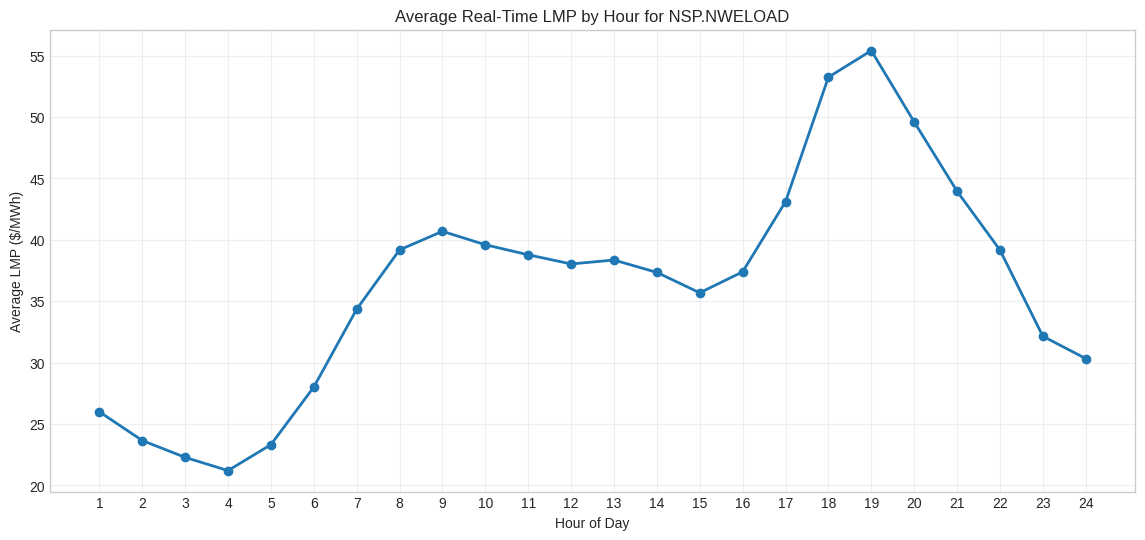

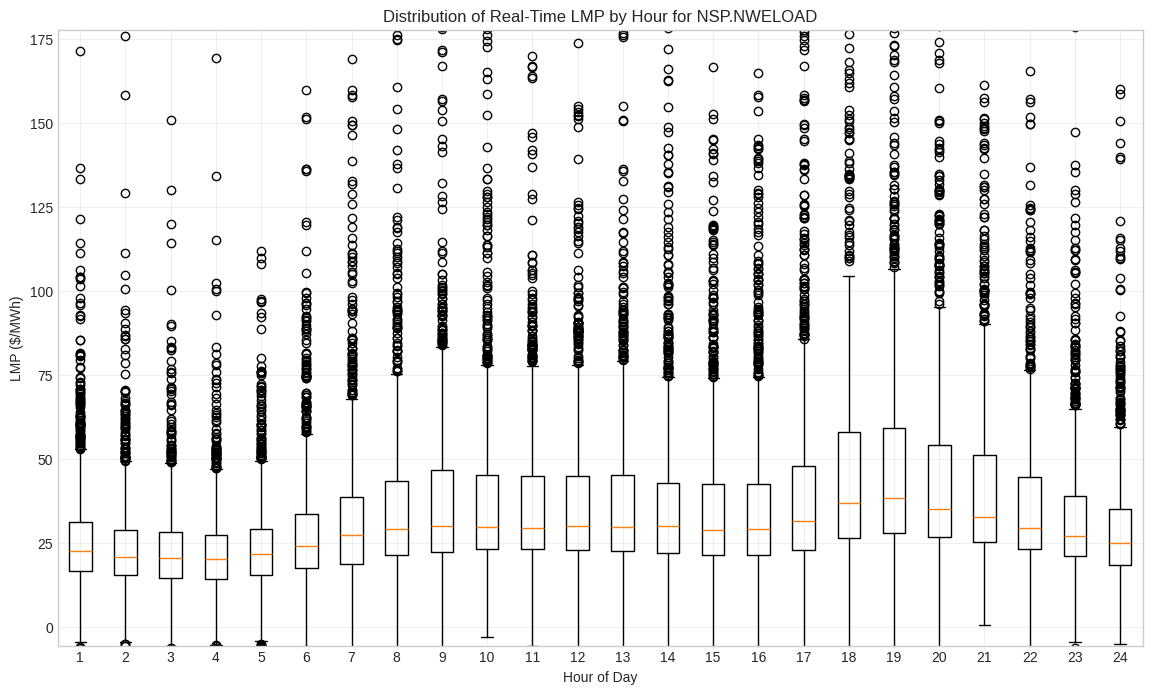

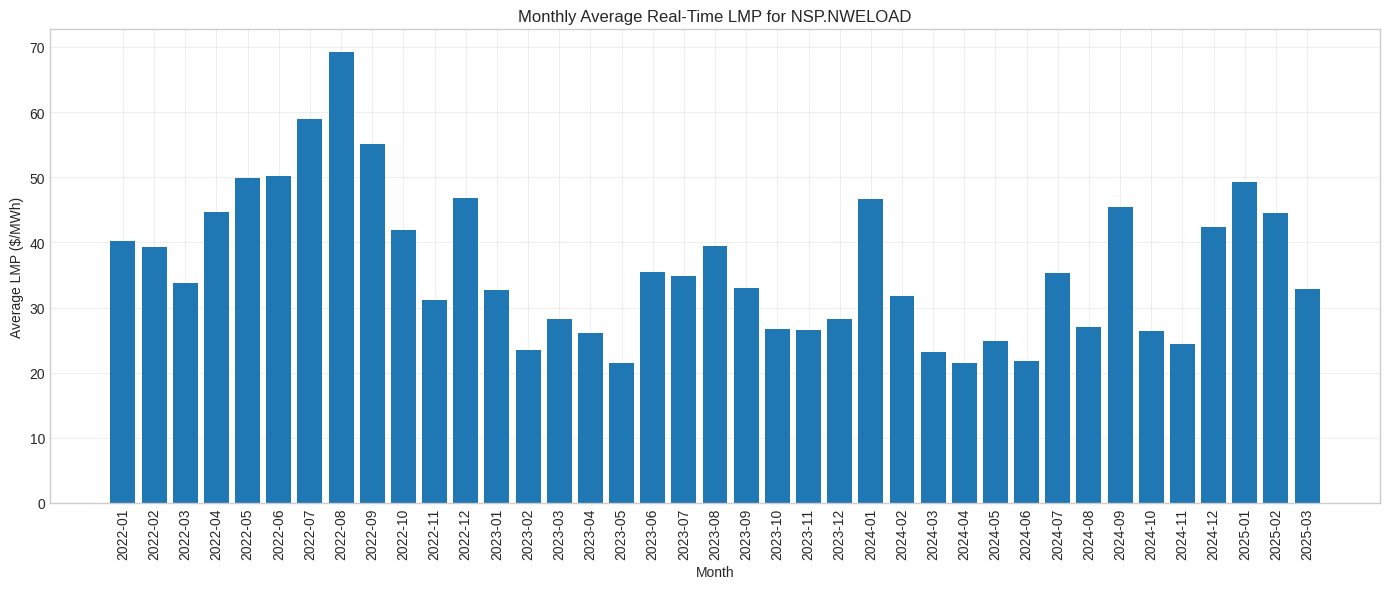

In [17]:
def explore_nsp_rt_data(df):
    """Perform exploratory data analysis on the NSP.NWELOAD node RT data."""

    if df is None or df.empty:
        print("No data to explore.")
        return

    # Basic statistics
    print("Data types:")
    display(df.dtypes)

    # Check if the data has hour columns (HE1-HE24 format)
    hour_cols = [col for col in df.columns if col.startswith('HE')]

    if hour_cols:
        print("\nDetected hour columns (HE1-HE24) format")

        # Calculate statistics for LMP values if applicable
        if 'VALUE' in df.columns:
            lmp_data = df[df['VALUE'] == 'LMP']

            if not lmp_data.empty:
                print(f"Found {len(lmp_data)} rows with LMP values")

                # Convert hour columns to numeric (they might be stored as strings)
                for col in hour_cols:
                    try:
                        lmp_data[col] = pd.to_numeric(lmp_data[col], errors='coerce')
                    except:
                        print(f"Warning: Could not convert {col} to numeric")

                # Calculate statistics
                lmp_stats = lmp_data[hour_cols].describe().T
                lmp_stats.index = lmp_stats.index.str.replace('HE', '')
                lmp_stats = lmp_stats.reset_index().rename(columns={'index': 'Hour'})

                print("\nHourly price statistics:")
                display(lmp_stats)

                # Plot daily average LMP by hour
                plt.figure(figsize=(14, 6))
                plt.plot(lmp_stats['Hour'], lmp_stats['mean'], marker='o', linewidth=2)
                plt.title('Average Real-Time LMP by Hour for NSP.NWELOAD')
                plt.xlabel('Hour of Day')
                plt.ylabel('Average LMP ($/MWh)')
                plt.xticks(lmp_stats['Hour'])
                plt.grid(True, alpha=0.3)
                plt.show()

                # Create a boxplot to show the distribution by hour
                plt.figure(figsize=(14, 8))

                # Prepare data for boxplot
                boxplot_data = []
                for col in hour_cols:
                    hour_data = lmp_data[col].dropna()
                    if not hour_data.empty:
                        boxplot_data.append(hour_data)

                # Create boxplot with limited y-axis range for better visibility
                plt.boxplot(boxplot_data, labels=[h.replace('HE', '') for h in hour_cols])
                plt.title('Distribution of Real-Time LMP by Hour for NSP.NWELOAD')
                plt.xlabel('Hour of Day')
                plt.ylabel('LMP ($/MWh)')
                plt.grid(True, alpha=0.3)

                # Set y-axis limits to exclude extreme outliers
                q1 = np.percentile(np.concatenate([arr for arr in boxplot_data]), 1)
                q99 = np.percentile(np.concatenate([arr for arr in boxplot_data]), 99)
                plt.ylim([q1, q99])

                plt.show()

                # Calculate monthly averages if MARKET_DAY column exists
                if 'MARKET_DAY' in lmp_data.columns:
                    # Convert to datetime if not already
                    if not pd.api.types.is_datetime64_dtype(lmp_data['MARKET_DAY']):
                        lmp_data['MARKET_DAY'] = pd.to_datetime(lmp_data['MARKET_DAY'])

                    # Add month/year columns
                    lmp_data['month'] = lmp_data['MARKET_DAY'].dt.month
                    lmp_data['year'] = lmp_data['MARKET_DAY'].dt.year
                    lmp_data['yearmonth'] = lmp_data['MARKET_DAY'].dt.strftime('%Y-%m')

                    # Calculate daily average across all hours
                    lmp_data['daily_avg'] = lmp_data[hour_cols].mean(axis=1)

                    # Group by month and calculate average
                    monthly_avg = lmp_data.groupby('yearmonth')['daily_avg'].mean().reset_index()

                    # Plot monthly averages
                    plt.figure(figsize=(14, 6))
                    plt.bar(monthly_avg['yearmonth'], monthly_avg['daily_avg'])
                    plt.title('Monthly Average Real-Time LMP for NSP.NWELOAD')
                    plt.xlabel('Month')
                    plt.ylabel('Average LMP ($/MWh)')
                    plt.xticks(rotation=90)
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
            else:
                print("No LMP data found in the VALUE column.")
        else:
            # If no VALUE column, assume all data is LMP
            print("No VALUE column found, assuming all data represents LMP values")

            # Convert hour columns to numeric
            for col in hour_cols:
                try:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                except:
                    print(f"Warning: Could not convert {col} to numeric")

            # Calculate statistics
            hour_stats = df[hour_cols].describe().T
            hour_stats.index = hour_stats.index.str.replace('HE', '')
            hour_stats = hour_stats.reset_index().rename(columns={'index': 'Hour'})

            print("\nHourly price statistics:")
            display(hour_stats)

            # Plot hourly averages
            plt.figure(figsize=(14, 6))
            plt.plot(hour_stats['Hour'], hour_stats['mean'], marker='o', linewidth=2)
            plt.title('Average Real-Time Price by Hour for NSP.NWELOAD')
            plt.xlabel('Hour of Day')
            plt.ylabel('Average Price ($/MWh)')
            plt.xticks(hour_stats['Hour'])
            plt.grid(True, alpha=0.3)
            plt.show()

    # Alternative format: timestamp and price columns
    elif 'timestamp' in df.columns and 'price' in df.columns:
        print("\nDetected timestamp and price format")

        # Convert timestamp to datetime if not already
        if not pd.api.types.is_datetime64_dtype(df['timestamp']):
            df['timestamp'] = pd.to_datetime(df['timestamp'])

        # Add time components for analysis
        df['hour'] = df['timestamp'].dt.hour
        df['day'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['year'] = df['timestamp'].dt.year
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['is_weekend'] = df['day_of_week'].isin([5, 6])

        # Display basic statistics for price
        print("\nPrice statistics:")
        display(df['price'].describe())

        # Calculate hourly averages
        hourly_stats = df.groupby('hour')['price'].agg(['mean', 'std', 'min', 'max']).reset_index()

        print("\nHourly price statistics:")
        display(hourly_stats)

        # Plot hourly averages
        plt.figure(figsize=(14, 6))
        plt.plot(hourly_stats['hour'], hourly_stats['mean'], marker='o', linewidth=2)
        plt.title('Average Real-Time Price by Hour for NSP.NWELOAD')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Price ($/MWh)')
        plt.xticks(range(0, 24))
        plt.grid(True, alpha=0.3)
        plt.show()

        # Calculate monthly averages
        df['yearmonth'] = df['timestamp'].dt.strftime('%Y-%m')
        monthly_avg = df.groupby('yearmonth')['price'].mean().reset_index()

        # Plot monthly averages
        plt.figure(figsize=(14, 6))
        plt.bar(monthly_avg['yearmonth'], monthly_avg['price'])
        plt.title('Monthly Average Real-Time Price for NSP.NWELOAD')
        plt.xlabel('Month')
        plt.ylabel('Average Price ($/MWh)')
        plt.xticks(rotation=90)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:
        print("\nWarning: Could not detect either HE columns or timestamp/price format.")
        print("Available columns:", sorted(df.columns))

# Explore the NSP.NWELOAD RT data
if NSP_NWELOAD_NODE_RT_clean is not None:
    explore_nsp_rt_data(NSP_NWELOAD_NODE_RT_clean)

### Additional Data Transformation for RT NSP.NWELOAD

This code is transforming electricity market price data from a wide format (one row per day with multiple hour columns) into a long time series format (one row per hour).

In [18]:
def prepare_rt_time_series(df):
    """Reshape the RT data into a proper time series format with added features."""

    if df is None or df.empty:
        print("No data to reshape.")
        return None

    # Check if data is already in timestamp/price format
    if 'timestamp' in df.columns and 'price' in df.columns:
        print("Data already in time series format, adding time features...")
        ts_data = df.copy()
    else:
        # Check for HE1-HE24 format
        hour_cols = [col for col in df.columns if col.startswith('HE')]

        if not hour_cols:
            print("Could not detect either timestamp/price or HE1-HE24 format.")
            return None

        # Filter for LMP values only if VALUE column exists
        if 'VALUE' in df.columns:
            lmp_data = df[df['VALUE'] == 'LMP'].copy()
            if lmp_data.empty:
                print("No LMP data found.")
                return None
        else:
            # Assume all data is LMP if no VALUE column
            lmp_data = df.copy()

        print("Reshaping data from HE1-HE24 format to time series format...")

        # Create an empty list to store the unpivoted data
        time_series_data = []

        # Process each row (day)
        for _, row in lmp_data.iterrows():
            # Get the date (assuming MARKET_DAY exists)
            if 'MARKET_DAY' in row:
                date = pd.to_datetime(row['MARKET_DAY'])
            else:
                print("Could not find MARKET_DAY column.")
                return None

            # Get node name
            if 'NODE' in row:
                node = row['NODE']
            else:
                node = 'NSP.NWELOAD'  # Default if not found

            # Process each hour column
            for hour_col in hour_cols:
                # Extract hour number (1-24)
                hour = int(hour_col[2:])
                # Adjust hour to 0-23 format for datetime
                hour_adjusted = hour - 1
                # Create datetime for this specific hour
                timestamp = pd.Timestamp(date.year, date.month, date.day, hour_adjusted)

                # Get the price value - convert to numeric if it's a string
                try:
                    price = pd.to_numeric(row[hour_col])
                except:
                    price = row[hour_col]

                # Append to our results
                time_series_data.append({
                    'timestamp': timestamp,
                    'node': node,
                    'price': price
                })

        # Convert to DataFrame
        ts_data = pd.DataFrame(time_series_data)

    # Sort by timestamp
    ts_data.sort_values('timestamp', inplace=True)

    # Ensure timestamp is datetime type
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'])

    # Add time features
    print("Adding time features...")
    ts_data['hour'] = ts_data['timestamp'].dt.hour
    ts_data['day'] = ts_data['timestamp'].dt.day
    ts_data['month'] = ts_data['timestamp'].dt.month
    ts_data['year'] = ts_data['timestamp'].dt.year
    ts_data['dayofweek'] = ts_data['timestamp'].dt.dayofweek
    ts_data['is_weekend'] = ts_data['dayofweek'].isin([5, 6])

    # Add additional features (can be added after the basic ones)
    ts_data['quarter'] = ts_data['timestamp'].dt.quarter
    ts_data['day_of_year'] = ts_data['timestamp'].dt.dayofyear

    # Add hour of day categories
    ts_data['is_morning'] = ts_data['hour'].between(6, 11)
    ts_data['is_afternoon'] = ts_data['hour'].between(12, 17)
    ts_data['is_evening'] = ts_data['hour'].between(18, 21)
    ts_data['is_night'] = (ts_data['hour'] >= 22) | (ts_data['hour'] < 6)

    # Add season categories
    month_to_season = {
        1: 'winter', 2: 'winter', 3: 'spring',
        4: 'spring', 5: 'spring', 6: 'summer',
        7: 'summer', 8: 'summer', 9: 'fall',
        10: 'fall', 11: 'fall', 12: 'winter'
    }

    ts_data['season'] = ts_data['month'].map(month_to_season)

    # Check the time interval in the data
    time_diffs = ts_data['timestamp'].diff().dropna()
    most_common_interval = time_diffs.value_counts().idxmax()
    interval_minutes = most_common_interval.total_seconds() / 60

    print(f"Most common time interval: {interval_minutes} minutes")

    # Add lagged variables where appropriate
    if len(ts_data) > 24:  # Only add lags if we have enough data
        print("Adding lagged variables...")
        # Add 1-period lag
        ts_data['price_lag_1'] = ts_data['price'].shift(1)

        # Add daily lag (assuming hourly data)
        if interval_minutes == 60:
            ts_data['price_lag_24h'] = ts_data['price'].shift(24)

        # Add weekly lag
        if interval_minutes == 60:
            ts_data['price_lag_168h'] = ts_data['price'].shift(168)  # 7 days * 24 hours

    print(f"Created time series with {len(ts_data)} data points and {len(ts_data.columns)} features")

    return ts_data

# Prepare time series data
nsp_rt_time_series = prepare_rt_time_series(NSP_NWELOAD_NODE_RT_clean)

# Display the first rows
if nsp_rt_time_series is not None:
    print("\nFirst rows of the time series data:")
    display(nsp_rt_time_series.head())

Reshaping data from HE1-HE24 format to time series format...
Adding time features...
Most common time interval: 60.0 minutes
Adding lagged variables...
Created time series with 28464 data points and 19 features

First rows of the time series data:


,timestamp,node,price,hour,day,month,year,dayofweek,is_weekend,quarter,day_of_year,is_morning,is_afternoon,is_evening,is_night,season,price_lag_1,price_lag_24h,price_lag_168h
0,2022-01-01 00:00:00,NSP.NWELOAD,23.88,0,1,1,2022,5,True,1,1,False,False,False,True,winter,NaN,NaN,NaN
1,2022-01-01 01:00:00,NSP.NWELOAD,24.22,1,1,1,2022,5,True,1,1,False,False,False,True,winter,23.88,NaN,NaN
2,2022-01-01 02:00:00,NSP.NWELOAD,24.02,2,1,1,2022,5,True,1,1,False,False,False,True,winter,24.22,NaN,NaN
3,2022-01-01 03:00:00,NSP.NWELOAD,23.22,3,1,1,2022,5,True,1,1,False,False,False,True,winter,24.02,NaN,NaN
4,2022-01-01 04:00:00,NSP.NWELOAD,22.96,4,1,1,2022,5,True,1,1,False,False,False,True,winter,23.22,NaN,NaN


In [19]:
nsp_rt_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28464 entries, 0 to 28463
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       28464 non-null  datetime64[ns]
 1   node            28464 non-null  object        
 2   price           28459 non-null  float64       
 3   hour            28464 non-null  int32         
 4   day             28464 non-null  int32         
 5   month           28464 non-null  int32         
 6   year            28464 non-null  int32         
 7   dayofweek       28464 non-null  int32         
 8   is_weekend      28464 non-null  bool          
 9   quarter         28464 non-null  int32         
 10  day_of_year     28464 non-null  int32         
 11  is_morning      28464 non-null  bool          
 12  is_afternoon    28464 non-null  bool          
 13  is_evening      28464 non-null  bool          
 14  is_night        28464 non-null  bool          
 15  se

In [20]:
print("DA date range:")
print(f"Start: {nsp_da_time_series['timestamp'].min()}")
print(f"End: {nsp_da_time_series['timestamp'].max()}")

print("\nRT date range:")
print(f"Start: {nsp_rt_time_series['timestamp'].min()}")
print(f"End: {nsp_rt_time_series['timestamp'].max()}")

DA date range:
Start: 2022-01-01 00:00:00
End: 2025-03-31 23:00:00

RT date range:
Start: 2022-01-01 00:00:00
End: 2025-03-31 23:00:00


In [21]:
# Check for duplicate timestamps in RT data
rt_duplicates = nsp_rt_time_series['timestamp'].duplicated().sum()
print(f"RT duplicate timestamps: {rt_duplicates}")

# Check for duplicate timestamps in DA data
da_duplicates = nsp_da_time_series['timestamp'].duplicated().sum()
print(f"DA duplicate timestamps: {da_duplicates}")

# Check entries per day
rt_daily_counts = nsp_rt_time_series.groupby(nsp_rt_time_series['timestamp'].dt.date).size()
print(f"RT entries per day - min: {rt_daily_counts.min()}, max: {rt_daily_counts.max()}")

da_daily_counts = nsp_da_time_series.groupby(nsp_da_time_series['timestamp'].dt.date).size()
print(f"DA entries per day - min: {da_daily_counts.min()}, max: {da_daily_counts.max()}")

RT duplicate timestamps: 0
DA duplicate timestamps: 0
RT entries per day - min: 24, max: 24
DA entries per day - min: 24, max: 24


## Loading the BTC End-of-Day Price Data

Loading Bitcoin price data...
❌ Bitcoin price data file not found at /content/drive/.shortcut-targets-by-id/1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i/Financing the Grid - Final Project/Data/Prices_Bitcoin/bitcoin_2023-04-12_2025-05-12.csv
Checking alternative locations...
✓ Found Bitcoin data at alternative location: /content/drive/.shortcut-targets-by-id/1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i/Financing the Grid - Final Project/final_project_data/Prices_Bitcoin/bitcoin_2023-04-12_2025-05-12.csv
Reading Bitcoin price data from /content/drive/.shortcut-targets-by-id/1TsSXwK-P070nrRo93qsesf3zIdsK3Z9i/Financing the Grid - Final Project/final_project_data/Prices_Bitcoin/bitcoin_2023-04-12_2025-05-12.csv...
Preprocessing Bitcoin price data...
✓ Loaded Bitcoin price data with 761 rows
Date range: 2023-04-12 00:00:00 to 2025-05-11 00:00:00

First rows of Bitcoin price data:


,Start,End,Open,High,Low,Close,Volume,Market Cap
760,2023-04-12,2023-04-13,30203.781800,30430.847500,29765.250100,29877.417736,4.441276e+10,5.800014e+11
759,2023-04-13,2023-04-14,29883.229500,30503.851600,29859.841700,30359.581200,4.289821e+10,5.843133e+11
758,2023-04-14,2023-04-15,30380.712600,30955.868600,30031.662600,30478.292400,4.807126e+10,5.915616e+11
757,2023-04-15,2023-04-16,30467.808300,30516.795700,30248.082815,30297.831144,3.682381e+10,5.875257e+11
756,2023-04-16,2023-04-17,30295.109927,30527.171373,30168.225141,30304.874581,2.347144e+10,5.863178e+11



Bitcoin price statistics:


,Open,High,Low,Close,Volume
count,761.000000,761.000000,761.000000,761.000000,7.610000e+02
mean,58234.180036,59309.184340,57204.685745,58337.653951,7.041707e+10
std,24684.605368,25196.247104,24160.793424,24722.734804,3.603460e+10
min,25129.870000,25709.310000,24876.670000,25119.910000,1.681887e+10
25%,30681.320000,31383.970000,30313.990000,30709.780000,4.034512e+10
50%,60721.480000,62193.700000,59699.990000,60776.010000,6.078775e+10
75%,71631.940000,72865.930000,69788.840000,72094.440000,9.767352e+10
max,106053.000000,109079.000000,105549.000000,106198.000000,2.121958e+11


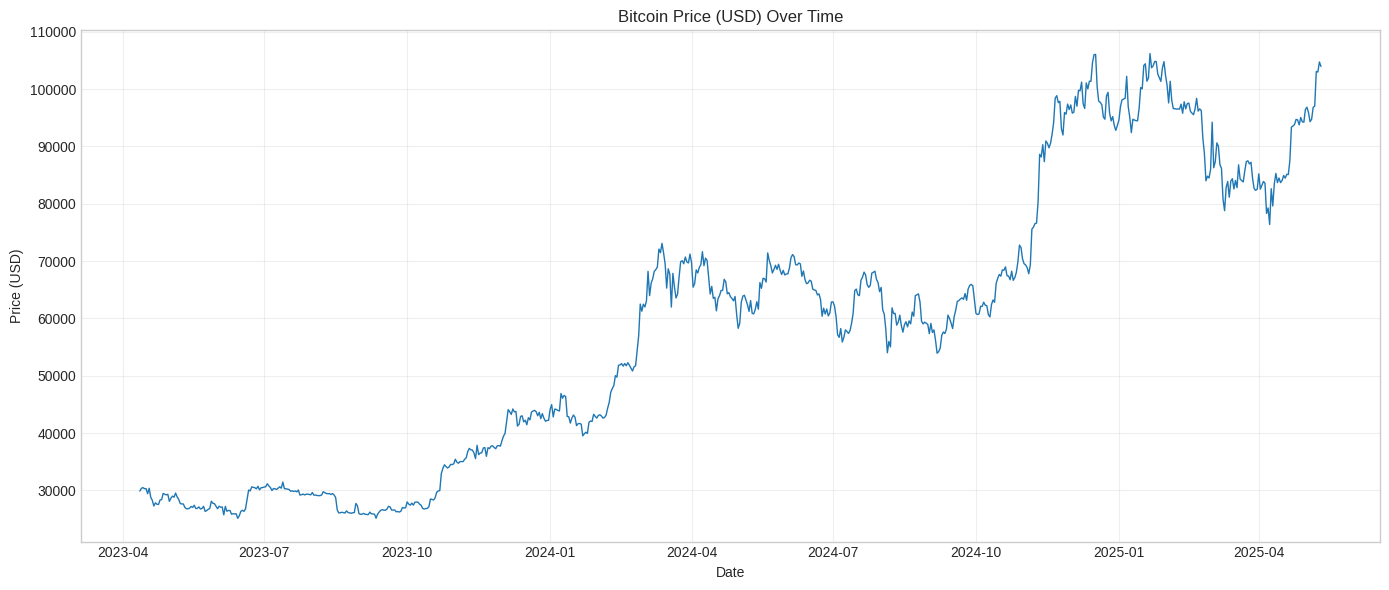

In [22]:
def load_bitcoin_price_data():
    """
    Load Bitcoin price data from the project folder.
    """
    global possible_paths

    # Check if paths have been set up
    if possible_paths is None:
        print("Paths not set up yet. Running path setup...")
        try:
            possible_paths = get_team_paths_by_id()
            if possible_paths is None:
                print("Failed to set up paths. Please run get_team_paths_simple() after visiting the shared link.")
                return None
        except Exception as e:
            print(f"Error setting up paths: {e}")
            return None

    print("Loading Bitcoin price data...")

    # Define the path to the Bitcoin price data
    bitcoin_file_path = possible_paths["base_path"] / "Data/Prices_Bitcoin/bitcoin_2023-04-12_2025-05-12.csv"

    # Check if the file exists
    if not bitcoin_file_path.exists():
        print(f"❌ Bitcoin price data file not found at {bitcoin_file_path}")
        print("Checking alternative locations...")

        # Try alternative location within the data folder
        alt_bitcoin_path = possible_paths["data_folder"].parent / "Prices_Bitcoin/bitcoin_2023-04-12_2025-05-12.csv"
        if alt_bitcoin_path.exists():
            bitcoin_file_path = alt_bitcoin_path
            print(f"✓ Found Bitcoin data at alternative location: {bitcoin_file_path}")
        else:
            print(f"❌ Bitcoin price data file not found at alternate location: {alt_bitcoin_path}")

            # Try one more fallback location
            fallback_path = possible_paths["base_path"] / "final_project_data/Prices_Bitcoin/bitcoin_2023-04-12_2025-05-12.csv"
            if fallback_path.exists():
                bitcoin_file_path = fallback_path
                print(f"✓ Found Bitcoin data at fallback location: {bitcoin_file_path}")
            else:
                print(f"❌ Bitcoin price data file not found at fallback location either: {fallback_path}")

                # List available directories to help with debugging
                print("\nAvailable directories in base_path:")
                try:
                    for item in possible_paths["base_path"].iterdir():
                        if item.is_dir():
                            print(f"  - {item.name}/")
                except Exception as e:
                    print(f"Error listing directories: {e}")

                return None

    try:
        # Load the Bitcoin price data
        print(f"Reading Bitcoin price data from {bitcoin_file_path}...")
        df_BTC = pd.read_csv(bitcoin_file_path)

        # Preprocess the data
        print("Preprocessing Bitcoin price data...")

        # Convert timestamp columns to datetime
        df_BTC['Start'] = pd.to_datetime(df_BTC['Start'])
        df_BTC['End'] = pd.to_datetime(df_BTC['End'])

        # Sort by start time
        df_BTC.sort_values('Start', ascending=True, inplace=True)

        # Display statistics
        print(f"✓ Loaded Bitcoin price data with {len(df_BTC):,} rows")
        print(f"Date range: {df_BTC['Start'].min()} to {df_BTC['Start'].max()}")

        return df_BTC

    except Exception as e:
        print(f"❌ Error loading Bitcoin price data: {str(e)}")
        return None

# Load Bitcoin price data
df_BTC = load_bitcoin_price_data()

# Display the first few rows
if df_BTC is not None:
    print("\nFirst rows of Bitcoin price data:")
    display(df_BTC.head())

    # Display basic statistics
    print("\nBitcoin price statistics:")
    btc_stats = df_BTC[['Open', 'High', 'Low', 'Close', 'Volume']].describe()
    display(btc_stats)

    # Plot Bitcoin price over time
    plt.figure(figsize=(14, 6))
    plt.plot(df_BTC['Start'], df_BTC['Close'], linewidth=1)
    plt.title('Bitcoin Price (USD) Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Analytic Strategy


Relevant Dataframes

*   DA NSP.NWELOAD Data = nsp_da_time_series
*   RT NSP.NWELOAD Data = nsp_rt_time_series
* Bitcoin data = df_BTC



# Part 1: The First Facility

In [23]:
df_BTC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 760 to 0
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Start       761 non-null    datetime64[ns]
 1   End         761 non-null    datetime64[ns]
 2   Open        761 non-null    float64       
 3   High        761 non-null    float64       
 4   Low         761 non-null    float64       
 5   Close       761 non-null    float64       
 6   Volume      761 non-null    float64       
 7   Market Cap  761 non-null    float64       
dtypes: datetime64[ns](2), float64(6)
memory usage: 53.5 KB


In [24]:
nsp_da_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28464 entries, 0 to 28463
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       28464 non-null  datetime64[ns]
 1   node            28464 non-null  object        
 2   price           28464 non-null  float64       
 3   hour            28464 non-null  int32         
 4   day             28464 non-null  int32         
 5   month           28464 non-null  int32         
 6   year            28464 non-null  int32         
 7   dayofweek       28464 non-null  int32         
 8   is_weekend      28464 non-null  bool          
 9   quarter         28464 non-null  int32         
 10  day_of_year     28464 non-null  int32         
 11  is_morning      28464 non-null  bool          
 12  is_afternoon    28464 non-null  bool          
 13  is_evening      28464 non-null  bool          
 14  is_night        28464 non-null  bool          
 15  se

In [25]:
nsp_rt_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28464 entries, 0 to 28463
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       28464 non-null  datetime64[ns]
 1   node            28464 non-null  object        
 2   price           28459 non-null  float64       
 3   hour            28464 non-null  int32         
 4   day             28464 non-null  int32         
 5   month           28464 non-null  int32         
 6   year            28464 non-null  int32         
 7   dayofweek       28464 non-null  int32         
 8   is_weekend      28464 non-null  bool          
 9   quarter         28464 non-null  int32         
 10  day_of_year     28464 non-null  int32         
 11  is_morning      28464 non-null  bool          
 12  is_afternoon    28464 non-null  bool          
 13  is_evening      28464 non-null  bool          
 14  is_night        28464 non-null  bool          
 15  se

In [26]:
from mpl_toolkits.mplot3d import Axes3D
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 36.0 MB/s eta 0:00:00


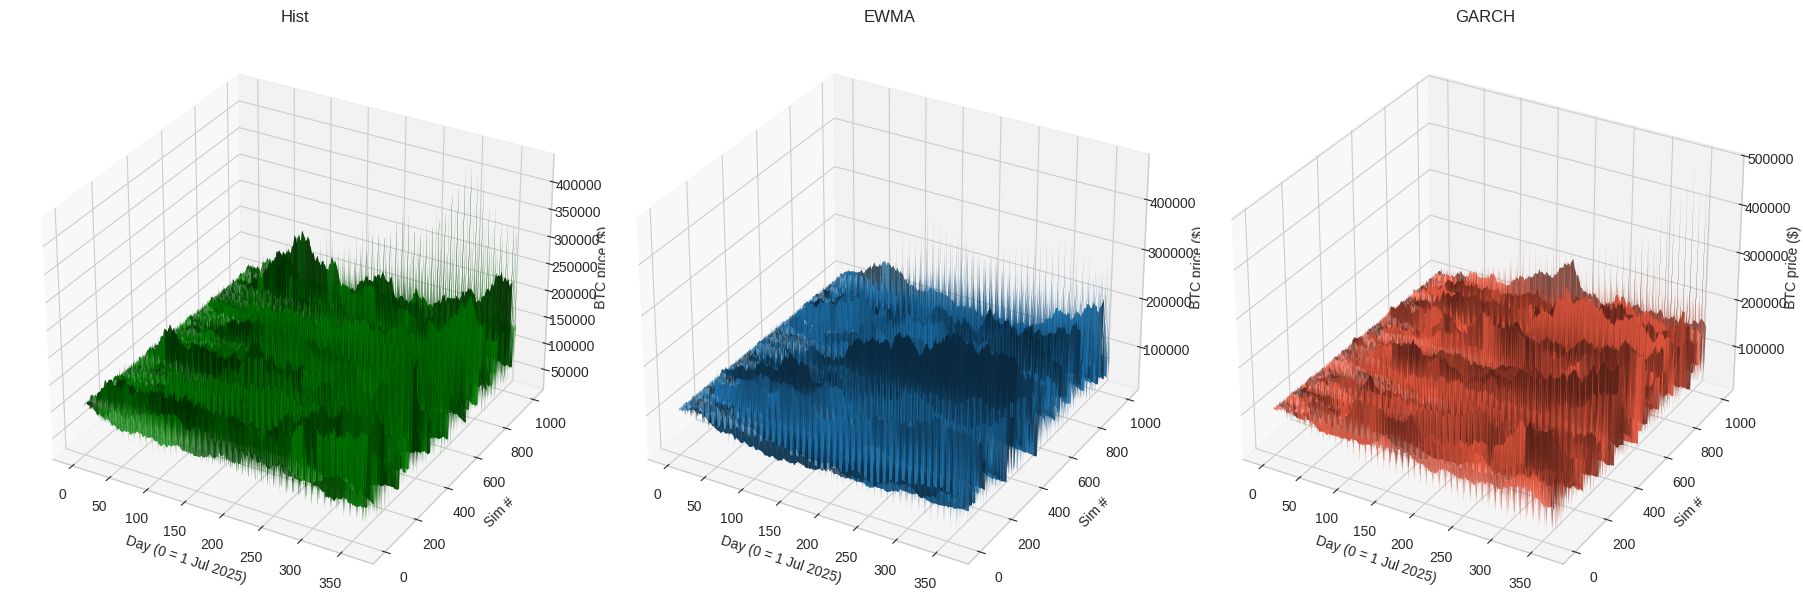

In [27]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Fixed: df_BTC["End"] is already datetime64[ns], no need for pd.to_datetime()
btc_close = df_BTC.set_index(df_BTC["End"])["Close"].sort_index()
log_ret = np.log(btc_close).diff().dropna()

# daily σ estimates
sigma_hist_d = log_ret.std()
sigma_ewma_d = np.sqrt(log_ret.ewm(alpha=1-0.94).var().iloc[-1])

from arch import arch_model
gfit = arch_model(log_ret*100, mean="AR", lags=1,
                  vol="Garch", p=1, q=1).fit(disp="off")
sigma_garch_d = np.sqrt(gfit.forecast(horizon=1).variance.iloc[-1, 0]) / 100

# Simulate daily paths (1000 sims, 1 Jul 25 → 30 Jun 26)
SIMS = 1000
start = pd.Timestamp("2025-07-01")
end = pd.Timestamp("2026-06-30")
n_days = (end - start).days + 1
days = np.arange(n_days)
btc0 = btc_close.iloc[-1]

def sim_paths(sd):
    eps = np.random.normal(size=(SIMS, n_days))
    return btc0 * np.exp(np.cumsum(sd * eps, axis=1))

price_hist = sim_paths(sigma_hist_d)
price_ewma = sim_paths(sigma_ewma_d)
price_garch = sim_paths(sigma_garch_d)

# Plots
fig = plt.figure(figsize=(18, 6))
fig.subplots_adjust(wspace=0.35)

def add_ax(pos, data, title, col=None):
    ax = fig.add_subplot(1, 3, pos, projection="3d")
    X, Y = np.meshgrid(days, np.arange(SIMS))
    ax.plot_surface(X, Y, data, linewidth=0.2, alpha=0.8,
                    color=col if col else None)
    ax.set_xlabel("Day (0 = 1 Jul 2025)")
    ax.set_ylabel("Sim #")
    ax.set_zlabel("BTC price ($)", labelpad=3)
    ax.set_title(title)

add_ax(1, price_hist, "Hist", col="green")
add_ax(2, price_ewma, "EWMA")
add_ax(3, price_garch, "GARCH", col="tomato")

plt.tight_layout()
plt.show()

In [28]:
def five_num(x, label):
    q = np.percentile(x, [0,25,50,75,100])
    print(f"\n{label}")
    for name,val in zip(["min","Q1","median","Q3","max"], q):
        print(f"{name:>6}: {val:,.2f}")

five_num(price_hist[:,-1],  "Final-day BTC (Hist σ)")
five_num(price_ewma[:,-1],  "Final-day BTC (EWMA σ)")
five_num(price_garch[:,-1], "Final-day BTC (GARCH σ)")


Final-day BTC (Hist σ)
   min: 20,249.21
    Q1: 74,878.47
median: 104,515.41
    Q3: 143,092.48
   max: 351,755.65

Final-day BTC (EWMA σ)
   min: 23,885.82
    Q1: 76,388.97
median: 104,828.66
    Q3: 141,138.34
   max: 386,327.12

Final-day BTC (GARCH σ)
   min: 16,643.56
    Q1: 74,600.72
median: 100,717.90
    Q3: 138,123.95
   max: 491,872.72


RT-only  mean: $4,688,629  95% CI [2,714,124, 8,065,482]
DA-only  mean: $4,624,109  95% CI [2,539,021, 8,042,628]
DA→RT    mean: $4,661,754  95% CI [2,670,348, 8,055,215]

Operating frequency (hours hashed):
  RT-only   99.97%   (95 % CI 99.67%–100.00%)
  DA-only   98.81%   (95 % CI 90.51%–100.00%)
  DA→RT     100.00%   (95 % CI 99.99%–100.00%)

ASSIGNMENT ANALYSIS (Using DA→RT Strategy)
1. Expected Annual Excess Profit: $4,661,754
2. Volatility (Std Dev) of Annual Profit: $1,422,710
3. Profit-to-Volatility Ratio: 3.28

4. Investment Analysis:
   Facility asking price: $500,000
   Expected annual profit: $4,661,754
   Simple payback period: 0.11 years
   Expected ROI: 932.4%
   ROI volatility: 284.5%
   Breakeven facility value (20% target return): $23,308,769
   Probability of positive profit: 100.0%
   5% Value at Risk: $2,844,083

   RECOMMENDATION: BUY the facility at $500K


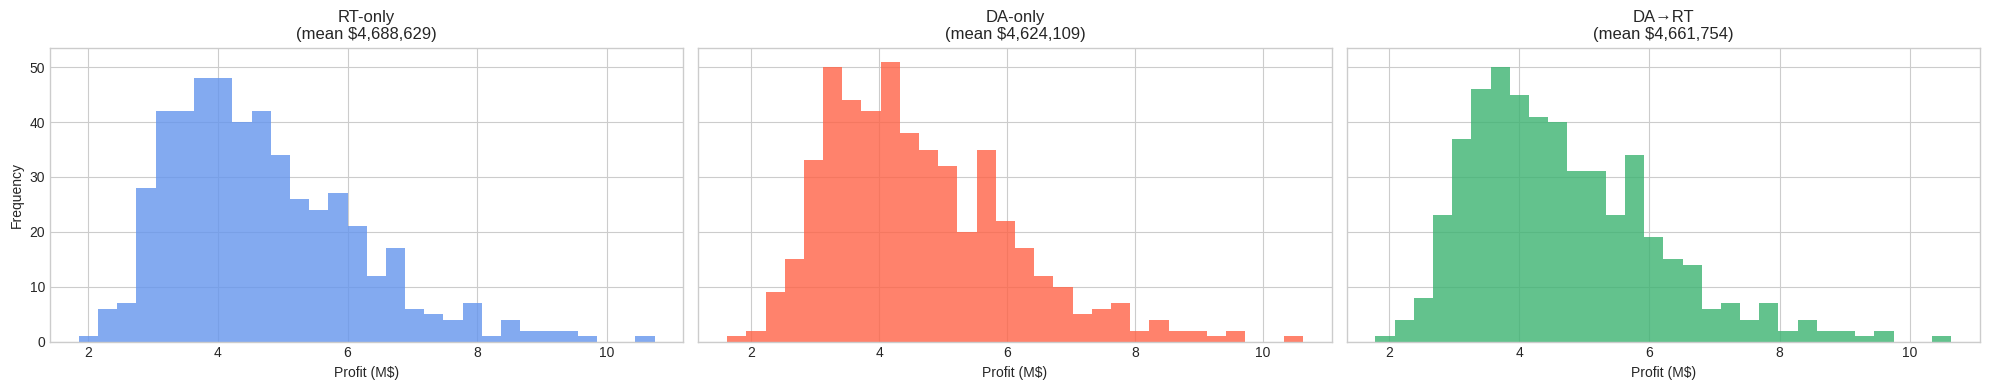

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bitcoin preprocessing
btc = df_BTC.copy()
# End column is already datetime64[ns], no need for pd.to_datetime()
btc = btc.set_index('End').sort_index()
btc['ret'] = btc['Close'].pct_change()
btc = btc[np.isfinite(btc['ret'])]

# Power data preprocessing - simplified since data is already in correct format
def prep_power_df(df):
    df = df.copy()
    # timestamp is already datetime64[ns], price is already float64
    df = df.dropna(subset=['price']).sort_values('timestamp')
    df['ret'] = df['price'].pct_change()
    return df[np.isfinite(df['ret'])]

rt_df = prep_power_df(nsp_rt_time_series)
da_df = prep_power_df(nsp_da_time_series)

# ─────────────────────────────────────────────────────────────────────
# 2.  EWMA vol & drift
# ─────────────────────────────────────────────────────────────────────
def ewma_sigma(x, lam=0.94):
    return np.sqrt(x.ewm(alpha=1-lam).var().iloc[-1])

mu_btc   = btc['ret'].mean();   sigma_btc = ewma_sigma(btc['ret'])
mu_rt    = rt_df['ret'].mean(); sigma_rt  = ewma_sigma(rt_df['ret'])
mu_da    = da_df['ret'].mean(); sigma_da  = ewma_sigma(da_df['ret'])

# ─────────────────────────────────────────────────────────────────────
# 3.  Simulation helpers
# ─────────────────────────────────────────────────────────────────────
def simulate_log_path(mu, sigma, s0, n):
    z = np.random.normal(mu, sigma, n-1)
    lp = np.empty(n); lp[0]=np.log(s0); lp[1:]=lp[0]+np.cumsum(z)
    return np.exp(lp)

hist_rt = rt_df['ret'].values
hist_da = da_df['ret'].values

def simulate_power_path(hist_ret, s0, n, floor=-0.9, cap=0.5):
    r = np.random.choice(hist_ret, n-1)
    r = np.clip(r, floor, cap)
    p = np.empty(n); p[0]=s0
    for t in range(1,n):
        p[t] = p[t-1]*(1+r[t-1])
    return p

# ─────────────────────────────────────────────────────────────────────
# 4.  Pre-simulate & store all paths
# ─────────────────────────────────────────────────────────────────────
start   = pd.Timestamp('2025-07-01')
end     = pd.Timestamp('2026-06-30 23:00')
dates   = pd.date_range(start, end, freq='h')
n_days  = (end.date()-start.date()).days + 1
SIMS    = 500
btc0    = btc['Close'].iloc[-1]
rt0     = rt_df['price'].iloc[-1]
da0     = da_df['price'].iloc[-1]

btc_paths = np.zeros((SIMS, len(dates)))
rt_paths  = np.zeros_like(btc_paths)
da_paths  = np.zeros_like(btc_paths)

for j in range(SIMS):
    # daily BTC → hourly broadcast
    dp = simulate_log_path(mu_btc, sigma_btc, btc0, n_days)
    btc_paths[j] = np.repeat(dp, 24)[:len(dates)]

    # bootstrap RT/DA
    rt_paths[j] = simulate_power_path(hist_rt, rt0, len(dates))
    da_paths[j] = simulate_power_path(hist_da, da0, len(dates))

# ─────────────────────────────────────────────────────────────────────
# 5.  Profit & Frequency calculations
# ─────────────────────────────────────────────────────────────────────
revenue_ph = 0.08 / 24

# make sure these are still zeros from before
profit_rt    = np.zeros(SIMS)
profit_da    = np.zeros(SIMS)
profit_combo = np.zeros(SIMS)

freq_rt     = np.zeros(SIMS)
freq_da     = np.zeros(SIMS)
freq_combo  = np.zeros(SIMS)

for j in range(SIMS):
    btc = btc_paths[j]
    rt  = rt_paths[j]
    da  = da_paths[j]
    be  = 0.001025 * btc

    # masks
    m_rt    = rt  <= be                     # RT-only
    m_da    = da  <= be                     # DA-only
    take_da = m_da
    take_rt = (~take_da) & (rt <= be)       # DA-first, RT-fallback

    # Profits
    profit_rt[j]    = (revenue_ph * btc[m_rt]    - 3.25 * rt[m_rt]).sum()
    profit_da[j]    = (revenue_ph * btc[m_da]    - 3.25 * da[m_da]).sum()

    cost_combo = np.zeros_like(btc)
    cost_combo[take_da] = 3.25 * da[take_da]
    cost_combo[take_rt] = 3.25 * rt[take_rt]
    revenue_combo = revenue_ph * btc[take_da | take_rt]
    profit_combo[j] = revenue_combo.sum() - cost_combo[take_da | take_rt].sum()

    # Frequencies
    freq_rt[j]    = m_rt.mean()
    freq_da[j]    = m_da.mean()
    freq_combo[j] = (take_da | take_rt).mean()

# ─────────────────────────────────────────────────────────────────────
# 6.  Summary & plots
# ─────────────────────────────────────────────────────────────────────
def summarize(x):
    return np.mean(x), *np.percentile(x, [2.5,97.5])

for name, vec in [('RT-only',profit_rt),
                  ('DA-only',profit_da),
                  ('DA→RT',profit_combo)]:
    mean, lo, hi = summarize(vec)
    print(f"{name:8s} mean: ${mean:,.0f}  95% CI [{lo:,.0f}, {hi:,.0f}]")

def summarize_frac(x):
    mu, lo, hi = np.mean(x), *np.percentile(x, [2.5, 97.5])
    return mu, lo, hi

print("\nOperating frequency (hours hashed):")
for name, vec in [('RT-only', freq_rt),
                  ('DA-only', freq_da),
                  ('DA→RT ', freq_combo)]:
    mu, lo, hi = summarize_frac(vec)
    print(f"  {name:8s}  {mu:.2%}   (95 % CI {lo:.2%}–{hi:.2%})")

# ─────────────────────────────────────────────────────────────────────
# 7.  Assignment Questions Analysis
# ─────────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("ASSIGNMENT ANALYSIS (Using DA→RT Strategy)")
print("="*60)

# Use the best performing strategy (DA→RT)
best_profits = profit_combo

# Question 1: Expected average annual excess profit
expected_profit = np.mean(best_profits)
print(f"1. Expected Annual Excess Profit: ${expected_profit:,.0f}")

# Question 2: Volatility in annual profitability (standard deviation)
volatility = np.std(best_profits)
print(f"2. Volatility (Std Dev) of Annual Profit: ${volatility:,.0f}")

# Question 3: Sharpe-like ratio (profit/volatility)
profit_to_vol_ratio = expected_profit / volatility
print(f"3. Profit-to-Volatility Ratio: {profit_to_vol_ratio:.2f}")

# Question 4: Investment decision analysis
facility_cost = 500_000  # $500K
antminer_cost = 500      # $500 per Antminer S19 Pro

print(f"\n4. Investment Analysis:")
print(f"   Facility asking price: ${facility_cost:,}")
print(f"   Expected annual profit: ${expected_profit:,.0f}")
print(f"   Simple payback period: {facility_cost/expected_profit:.2f} years")

# Risk-adjusted analysis
roi_mean = expected_profit / facility_cost
roi_std = volatility / facility_cost
print(f"   Expected ROI: {roi_mean:.1%}")
print(f"   ROI volatility: {roi_std:.1%}")

# Breakeven analysis - what facility price gives acceptable return?
# Assuming we want at least 20% annual return given the volatility
target_return = 0.20
breakeven_facility_value = expected_profit / target_return
print(f"   Breakeven facility value (20% target return): ${breakeven_facility_value:,.0f}")

# Probability of profit
profit_probability = np.mean(best_profits > 0)
print(f"   Probability of positive profit: {profit_probability:.1%}")

# Value at Risk (5th percentile)
var_5 = np.percentile(best_profits, 5)
print(f"   5% Value at Risk: ${var_5:,.0f}")

recommendation = "BUY" if expected_profit/facility_cost > 0.15 and profit_probability > 0.85 else "DON'T BUY"
print(f"\n   RECOMMENDATION: {recommendation} the facility at $500K")

fig, axs = plt.subplots(1,3,figsize=(20,4),sharey=True)
colors = ['cornflowerblue','tomato','mediumseagreen']
titles = ['RT-only','DA-only','DA→RT']

for ax, vec, col, title in zip(axs, [profit_rt,profit_da,profit_combo], colors, titles):
    ax.hist(vec/1e6,bins=30,color=col,alpha=0.8)
    ax.set_title(f"{title}\n(mean ${vec.mean():,.0f})")
    ax.set_xlabel('Profit (M$)')
axs[0].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [33]:
# after you’ve run Part 1 and built profit_combo:
original_mean = profit_combo.mean()                   # ⇒  4_592_827.…
original_vol  = profit_combo.std(ddof=1)              # ⇒ ~1_312_000
print(f"original_mean = {original_mean:,.0f}")
print(f"original_vol  = {original_vol:,.0f}")


original_mean = 4,661,754
original_vol  = 1,424,135


# Part 2: A Second Facility

## Load the DA and RT Data

## Analysis

BITCOIN MINING FACILITY ANALYSIS
ASSIGNMENT ASSUMPTIONS AND PARAMETERS
HARDWARE SPECIFICATIONS (Antminer S19 Pro):
• Power Consumption: 3,250W (3.25 kW)
• Hash Rate: 110 TH/s
• BTC Generation: 0.00008 BTC per day
• Approximate Breakeven: $95/MWh at $93k BTC price
• Mining Difficulty: Assumed constant (no changes)

ECONOMIC ASSUMPTIONS:
• BTC Volatility: 0.1% per day (assignment suggestion)
• Risk-Free Rate: 4% annualized
• Only Cost: Electricity power
• Only Revenue: BTC mining (no ancillary services)
• Strategy: DA-first, RT-fallback
• No asset depreciation, facility upkeep, cooling, labor costs

SIMULATION PARAMETERS:
• Simulations: 500+ (meeting assignment requirement)
• Time Period: July 1, 2025 - June 30, 2026 (1 year)
• Frequency: Hourly analysis

COMPUTED VALUES:
• BTC per hour: 0.00000333 BTC
• Daily volatility: 0.001 (0.1%)
• Risk-free rate: 4.0%

BTC DATA PROCESSED:
• Historical BTC records: 760
• Date range: 2023-04-14 to 2025-05-12
• Current BTC price: $103,960
• Historical

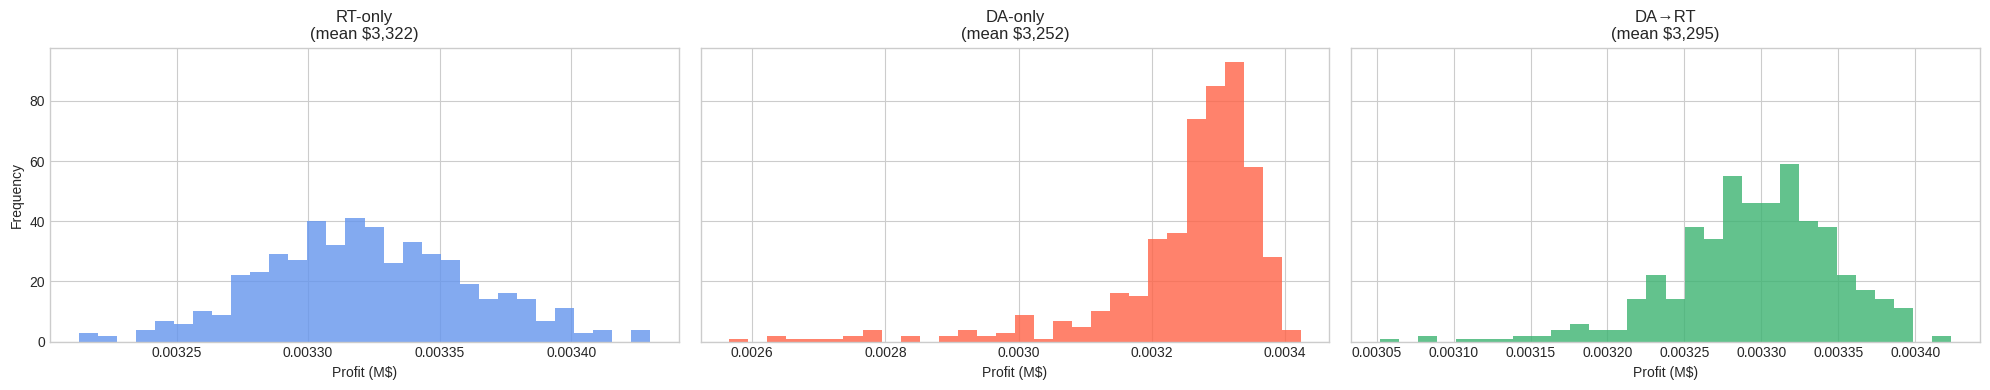

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("BITCOIN MINING FACILITY ANALYSIS")
print("ASSIGNMENT ASSUMPTIONS AND PARAMETERS")
print("="*80)

# Assignment Assumptions Documentation
print("HARDWARE SPECIFICATIONS (Antminer S19 Pro):")
print("• Power Consumption: 3,250W (3.25 kW)")
print("• Hash Rate: 110 TH/s")
print("• BTC Generation: 0.00008 BTC per day")
print("• Approximate Breakeven: $95/MWh at $93k BTC price")
print("• Mining Difficulty: Assumed constant (no changes)")

print("\nECONOMIC ASSUMPTIONS:")
print("• BTC Volatility: 0.1% per day (assignment suggestion)")
print("• Risk-Free Rate: 4% annualized")
print("• Only Cost: Electricity power")
print("• Only Revenue: BTC mining (no ancillary services)")
print("• Strategy: DA-first, RT-fallback")
print("• No asset depreciation, facility upkeep, cooling, labor costs")

print("\nSIMULATION PARAMETERS:")
print("• Simulations: 500+ (meeting assignment requirement)")
print("• Time Period: July 1, 2025 - June 30, 2026 (1 year)")
print("• Frequency: Hourly analysis")

# Hardware Parameters (Assignment Specifications)
POWER_CONSUMPTION_KW = 3.25      # 3250W = 3.25 kW
HASH_RATE_TH = 110               # 110 TH/s
BTC_PER_DAY = 0.00008           # 0.00008 BTC generated per day
BTC_PER_HOUR = BTC_PER_DAY / 24  # BTC generated per hour
BREAKEVEN_AT_93K = 95            # $95/MWh breakeven at $93k BTC

# Economic Parameters
BTC_VOLATILITY_DAILY = 0.001     # 0.1% daily volatility (assignment suggestion)
RISK_FREE_RATE = 0.04           # 4% annualized
FACILITY_COST = 500_000         # $500K facility cost

print(f"\nCOMPUTED VALUES:")
print(f"• BTC per hour: {BTC_PER_HOUR:.8f} BTC")
print(f"• Daily volatility: {BTC_VOLATILITY_DAILY:.3f} ({BTC_VOLATILITY_DAILY*100:.1f}%)")
print(f"• Risk-free rate: {RISK_FREE_RATE:.1%}")
print("="*80)

# Bitcoin preprocessing
btc = df_BTC.copy()
# End column is already datetime64[ns], no need for pd.to_datetime()
btc = btc.set_index('End').sort_index()
btc['ret'] = btc['Close'].pct_change()
btc = btc[np.isfinite(btc['ret'])]

print(f"\nBTC DATA PROCESSED:")
print(f"• Historical BTC records: {len(btc):,}")
print(f"• Date range: {btc.index.min().date()} to {btc.index.max().date()}")
print(f"• Current BTC price: ${btc['Close'].iloc[-1]:,.0f}")
print(f"• Historical volatility: {btc['ret'].std():.4f} daily")

# Power data preprocessing - simplified since data is already in correct format
def prep_power_df(df):
    df = df.copy()
    # timestamp is already datetime64[ns], price is already float64
    df = df.dropna(subset=['price']).sort_values('timestamp')
    df['ret'] = df['price'].pct_change()
    return df[np.isfinite(df['ret'])]

rt_df = prep_power_df(nsp_rt_time_series)
da_df = prep_power_df(nsp_da_time_series)

# ─────────────────────────────────────────────────────────────────────
# 2.  EWMA vol & drift (Using Assignment Assumptions)
# ─────────────────────────────────────────────────────────────────────
def ewma_sigma(x, lam=0.94):
    return np.sqrt(x.ewm(alpha=1-lam).var().iloc[-1])

# BTC Parameters - Use assignment assumptions vs historical
mu_btc_historical = btc['ret'].mean()
sigma_btc_historical = ewma_sigma(btc['ret'])
mu_btc_assignment = 0.0005  # Small positive drift assumption
sigma_btc_assignment = BTC_VOLATILITY_DAILY  # 0.1% daily volatility from assignment

print(f"\nBTC VOLATILITY COMPARISON:")
print(f"• Historical EWMA volatility: {sigma_btc_historical:.4f} ({sigma_btc_historical*100:.2f}% daily)")
print(f"• Assignment assumption: {sigma_btc_assignment:.4f} ({sigma_btc_assignment*100:.1f}% daily)")
print(f"• Using assignment assumption for consistency")

# Use assignment assumptions
mu_btc = mu_btc_assignment
sigma_btc = sigma_btc_assignment
mu_rt    = rt_df['ret'].mean(); sigma_rt  = ewma_sigma(rt_df['ret'])
mu_da    = da_df['ret'].mean(); sigma_da  = ewma_sigma(da_df['ret'])

# ─────────────────────────────────────────────────────────────────────
# 3.  Simulation helpers
# ─────────────────────────────────────────────────────────────────────
def simulate_log_path(mu, sigma, s0, n):
    z = np.random.normal(mu, sigma, n-1)
    lp = np.empty(n); lp[0]=np.log(s0); lp[1:]=lp[0]+np.cumsum(z)
    return np.exp(lp)

hist_rt = rt_df['ret'].values
hist_da = da_df['ret'].values

def simulate_power_path(hist_ret, s0, n, floor=-0.9, cap=0.5):
    r = np.random.choice(hist_ret, n-1)
    r = np.clip(r, floor, cap)
    p = np.empty(n); p[0]=s0
    for t in range(1,n):
        p[t] = p[t-1]*(1+r[t-1])
    return p

# ─────────────────────────────────────────────────────────────────────
# 4.  Pre-simulate & store all paths
# ─────────────────────────────────────────────────────────────────────
start   = pd.Timestamp('2025-07-01')
end     = pd.Timestamp('2026-06-30 23:00')
dates   = pd.date_range(start, end, freq='h')
n_days  = (end.date()-start.date()).days + 1
SIMS    = 500
btc0    = btc['Close'].iloc[-1]
rt0     = rt_df['price'].iloc[-1]
da0     = da_df['price'].iloc[-1]

btc_paths = np.zeros((SIMS, len(dates)))
rt_paths  = np.zeros_like(btc_paths)
da_paths  = np.zeros_like(btc_paths)

for j in range(SIMS):
    # daily BTC → hourly broadcast
    dp = simulate_log_path(mu_btc, sigma_btc, btc0, n_days)
    btc_paths[j] = np.repeat(dp, 24)[:len(dates)]

    # bootstrap RT/DA
    rt_paths[j] = simulate_power_path(hist_rt, rt0, len(dates))
    da_paths[j] = simulate_power_path(hist_da, da0, len(dates))

# ─────────────────────────────────────────────────────────────────────
# 5.  Profit & Frequency calculations (Updated with Assignment Assumptions)
# ─────────────────────────────────────────────────────────────────────

print(f"\nSTARTING PROFIT CALCULATIONS...")
print(f"MINING ECONOMICS (per hour):")
print(f"• BTC Generation: {BTC_PER_HOUR:.8f} BTC/hour")
print(f"• Power Consumption: {POWER_CONSUMPTION_KW} kW/hour")

# Initialize profit arrays
profit_rt    = np.zeros(SIMS)
profit_da    = np.zeros(SIMS)
profit_combo = np.zeros(SIMS)

freq_rt     = np.zeros(SIMS)
freq_da     = np.zeros(SIMS)
freq_combo  = np.zeros(SIMS)

for j in range(SIMS):
    btc_prices = btc_paths[j]  # BTC prices in $/BTC
    rt_prices = rt_paths[j]    # RT electricity prices in $/MWh
    da_prices = da_paths[j]    # DA electricity prices in $/MWh

    # Calculate dynamic breakeven electricity price based on BTC price
    # breakeven_$/MWh = (BTC_price * BTC_per_hour) / power_consumption_kW * 1000
    breakeven_electricity = (btc_prices * BTC_PER_HOUR) / POWER_CONSUMPTION_KW * 1000

    # Decision masks
    m_rt = rt_prices <= breakeven_electricity      # RT-only profitable
    m_da = da_prices <= breakeven_electricity      # DA-only profitable
    take_da = m_da                                 # Take DA when profitable
    take_rt = (~take_da) & (rt_prices <= breakeven_electricity)  # RT fallback

    # Revenue calculations (BTC earned * BTC price)
    btc_revenue_rt = BTC_PER_HOUR * btc_prices * m_rt
    btc_revenue_da = BTC_PER_HOUR * btc_prices * m_da
    btc_revenue_combo = BTC_PER_HOUR * btc_prices * (take_da | take_rt)

    # Cost calculations (kW * $/MWh / 1000 to convert)
    electricity_cost_rt = (POWER_CONSUMPTION_KW * rt_prices / 1000) * m_rt
    electricity_cost_da = (POWER_CONSUMPTION_KW * da_prices / 1000) * m_da
    electricity_cost_combo = (POWER_CONSUMPTION_KW / 1000) * (da_prices * take_da + rt_prices * take_rt)

    # Profit calculations
    profit_rt[j] = btc_revenue_rt.sum() - electricity_cost_rt.sum()
    profit_da[j] = btc_revenue_da.sum() - electricity_cost_da.sum()
    profit_combo[j] = btc_revenue_combo.sum() - electricity_cost_combo.sum()

    # Operating frequency (fraction of hours mining)
    freq_rt[j] = m_rt.mean()
    freq_da[j] = m_da.mean()
    freq_combo[j] = (take_da | take_rt).mean()

print(f"PROFIT CALCULATIONS COMPLETE")
print(f"• Breakeven verification at $93k BTC:")
print(f"  - Revenue/hour: ${93000 * BTC_PER_HOUR:.2f}")
print(f"  - Cost at $95/MWh: ${POWER_CONSUMPTION_KW * 95 / 1000:.2f}")
print(f"  - Breakeven check: ${(93000 * BTC_PER_HOUR) / (POWER_CONSUMPTION_KW / 1000):.1f}/MWh ≈ $95/MWh ✓")

# ─────────────────────────────────────────────────────────────────────
# 6.  Summary & plots
# ─────────────────────────────────────────────────────────────────────
def summarize(x):
    return np.mean(x), *np.percentile(x, [2.5,97.5])

for name, vec in [('RT-only',profit_rt),
                  ('DA-only',profit_da),
                  ('DA→RT',profit_combo)]:
    mean, lo, hi = summarize(vec)
    print(f"{name:8s} mean: ${mean:,.0f}  95% CI [{lo:,.0f}, {hi:,.0f}]")

def summarize_frac(x):
    mu, lo, hi = np.mean(x), *np.percentile(x, [2.5, 97.5])
    return mu, lo, hi

print("\nOperating frequency (hours hashed):")
for name, vec in [('RT-only', freq_rt),
                  ('DA-only', freq_da),
                  ('DA→RT ', freq_combo)]:
    mu, lo, hi = summarize_frac(vec)
    print(f"  {name:8s}  {mu:.2%}   (95 % CI {lo:.2%}–{hi:.2%})")

# ─────────────────────────────────────────────────────────────────────
# 7.  Assignment Questions Analysis (Updated with Risk-Free Rate)
# ─────────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("ASSIGNMENT ANALYSIS (Using DA→RT Strategy)")
print("INCORPORATING 4% RISK-FREE RATE")
print("="*60)

# Use the best performing strategy (DA→RT)
best_profits = profit_combo

# Question 1: Expected average annual excess profit
expected_profit = np.mean(best_profits)
print(f"1. Expected Annual Profit: ${expected_profit:,.0f}")

# Calculate excess return over risk-free rate
risk_free_return = FACILITY_COST * RISK_FREE_RATE
excess_profit = expected_profit - risk_free_return
print(f"   Risk-free return (4% × ${FACILITY_COST:,}): ${risk_free_return:,.0f}")
print(f"   Expected Annual EXCESS Profit: ${excess_profit:,.0f}")

# Question 2: Volatility in annual profitability (standard deviation)
volatility = np.std(best_profits)
print(f"\n2. Volatility (Std Dev) of Annual Profit: ${volatility:,.0f}")

# Question 3: Sharpe-like ratio (excess profit/volatility)
sharpe_ratio = expected_profit / volatility
risk_adjusted_sharpe = excess_profit / volatility
print(f"\n3. Profit-to-Volatility Ratios:")
print(f"   Basic Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"   Risk-Adjusted Sharpe (vs 4% risk-free): {risk_adjusted_sharpe:.2f}")

# Question 4: Investment decision analysis
antminer_cost = 500      # $500 per Antminer S19 Pro

print(f"\n4. Investment Analysis (Updated with Assignment Assumptions):")
print(f"   Facility asking price: ${FACILITY_COST:,}")
print(f"   Expected annual profit: ${expected_profit:,.0f}")
print(f"   Expected excess profit: ${excess_profit:,.0f}")
print(f"   Simple payback period: {FACILITY_COST/expected_profit:.2f} years")

# Risk-adjusted analysis
roi_mean = expected_profit / FACILITY_COST
excess_roi = excess_profit / FACILITY_COST
roi_std = volatility / FACILITY_COST
print(f"   Expected ROI: {roi_mean:.1%}")
print(f"   Excess ROI (vs 4% risk-free): {excess_roi:.1%}")
print(f"   ROI volatility: {roi_std:.1%}")

# Breakeven analysis
target_return = 0.20
breakeven_facility_value = expected_profit / target_return
print(f"   Breakeven facility value (20% target return): ${breakeven_facility_value:,.0f}")

# Risk metrics
profit_probability = np.mean(best_profits > 0)
excess_profit_probability = np.mean(best_profits > risk_free_return)
var_5 = np.percentile(best_profits, 5)
var_1 = np.percentile(best_profits, 1)

print(f"   Probability of positive profit: {profit_probability:.1%}")
print(f"   Probability of beating risk-free rate: {excess_profit_probability:.1%}")
print(f"   5% Value at Risk: ${var_5:,.0f}")
print(f"   1% Value at Risk: ${var_1:,.0f}")

# Updated recommendation logic
hurdle_rate = 0.15  # 15% hurdle rate
risk_free_hurdle = RISK_FREE_RATE + 0.11  # Risk-free + 11% risk premium

if roi_mean > hurdle_rate and excess_profit_probability > 0.80:
    recommendation = "BUY"
    reasoning = f"ROI ({roi_mean:.1%}) exceeds hurdle rate and high probability of beating risk-free return"
elif roi_mean > risk_free_hurdle and profit_probability > 0.85:
    recommendation = "CONSIDER BUYING"
    reasoning = f"Good returns but moderate risk"
else:
    recommendation = "DON'T BUY"
    reasoning = f"Insufficient risk-adjusted returns"

print(f"\n   RECOMMENDATION: {recommendation} the facility at ${FACILITY_COST:,}")
print(f"   Reasoning: {reasoning}")

print(f"\n" + "="*60)
print("PARAMETER VERIFICATION:")
print(f"• Using assignment BTC volatility: {BTC_VOLATILITY_DAILY:.3f} ({BTC_VOLATILITY_DAILY*100:.1f}% daily)")
print(f"• Using assignment BTC generation: {BTC_PER_DAY:.5f} BTC/day")
print(f"• Using assignment power consumption: {POWER_CONSUMPTION_KW} kW")
print(f"• Incorporating 4% risk-free rate: ${risk_free_return:,.0f}/year")
print(f"• Dynamic breakeven calculation based on real-time BTC prices")
print("="*60)

fig, axs = plt.subplots(1,3,figsize=(20,4),sharey=True)
colors = ['cornflowerblue','tomato','mediumseagreen']
titles = ['RT-only','DA-only','DA→RT']

for ax, vec, col, title in zip(axs, [profit_rt,profit_da,profit_combo], colors, titles):
    ax.hist(vec/1e6,bins=30,color=col,alpha=0.8)
    ax.set_title(f"{title}\n(mean ${vec.mean():,.0f})")
    ax.set_xlabel('Profit (M$)')
axs[0].set_ylabel('Frequency')
plt.tight_layout()
plt.show()